In [1]:
#@title imports 
import os
import pickle
from typing import Set
# from jedi import settings
import numpy as np 
import matplotlib.pyplot as plt
from numpy.lib.function_base import append 
import scipy.io as spio
from scipy.io import loadmat, savemat
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from scipy.sparse import data 
import pandas as pd 
import matplotlib as mpl 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# import umap.plot as uplot
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
import sys 
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
from UMAP import *
pd.options.mode.use_inf_as_na = True

In [2]:
def plot_UMAP_clusters_single(data_inh, neighbours, distance, res_louvain, random_state,annotate=False,norm=True, c_list=None ,savepath=None,save=False):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data_inh)
    if norm:
        data_umap = normalize(data_umap)
    
    neighbours = neighbours
    dist = distance
    reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
    mapper = reducer.fit(data_umap)
    
    fig = plt.figure(figsize=[8,8])
    ax12d = fig.add_subplot(1,1,1)
    
    louvain = Louvain(resolution=res_louvain,random_state=random_state)
    adjacency = mapper.graph_
    labels_exc = louvain.fit_predict(adjacency)

    print(len(set(labels_exc)))
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_umap)



    df_2d_exc = {'UMAP1':clusterable_embedding2d[:, 0],
             'UMAP2':clusterable_embedding2d[:, 1],
             'class':labels_exc}

    ax12d.set_xticks([])
    ax12d.set_yticks([])

    sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
    if annotate:
        for i in range(len(clusterable_embedding2d)):

            plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))

        # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax12d)

        # ax12d.set_title('UMAP clusters for excitatory neurons 2D')
        ax12d.legend()
    if save:
        plt.savefig(savepath,dpi=200)
    
    plt.show()

    return labels_exc,mapper,reducer

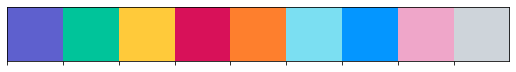

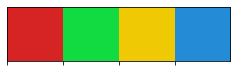

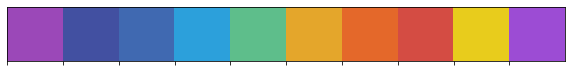

In [3]:
pal = ["#00202e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380"]
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283, 0.724],
                    [0.259,	0.314, 0.635],
                    [0.251,	0.412, 0.698],
                    [0.176,	0.631, 0.859],
                    [0.369,	0.749, 0.549],
                    [0.898,	0.654, 0.169],
                    [0.898,	0.41 , 0.165],
                    [0.834,	0.3 , 0.265],
                    [0.912,	0.8 , 0.112],
                    [0.612,	0.3 , 0.834]]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

In [4]:

features_ext = ['current_at_first_spike','ap_count','fr','inst_fr','time_to_first_spike','mean_isi','median_isi','max_isi',
'min_isi','first_thr','mean_thr','median_thr','min_thr','max_thr','mean_width','median_width','max_width',
'min_width','mean_amplitude','median_amplitude','min_amplitude','max_amplitude','exp_name','cond','trialnr']
features_ext_sub = ['current_at_first_spike','ap_count','fr','inst_fr','time_to_first_spike','mean_isi','median_isi','max_isi',
'min_isi','first_thr','mean_thr','median_thr','min_thr','max_thr','mean_width','median_width','max_width',
'min_width','mean_amplitude','median_amplitude','min_amplitude','max_amplitude']
data_all_conds = pickle.load(open('G:/My Drive/Cluster Feature files/Niccolo_FN.pkl','rb'))
exc = data_all_conds['exc']
inh = data_all_conds['inh']
def lower(data):
    return data.lower()
exc_df_all = pd.DataFrame(exc,columns = features_ext)
inh_df_all = pd.DataFrame(inh,columns = features_ext)
exc_inh_df = pd.concat([exc_df_all,inh_df_all])
exc_inh_df.index = np.arange(len(exc_inh_df))
inds =set(np.where(exc_inh_df.isna())[0])

exc_inh_df['ei_labels'] = np.concatenate((np.repeat(0,len(exc_df_all)),np.repeat(1,len(inh_df_all))))
exc_inh_df = exc_inh_df.drop(inds,axis=0)

date = [i.split('_')[1] for i in  exc_inh_df.exp_name]
name = [i.split('_')[0] for i in  exc_inh_df.exp_name]
exp_number = [i.split('_')[-1] for i in  exc_inh_df.exp_name]
exc_inh_df['date'] = date
exc_inh_df['name'] = name
exc_inh_df['exp_number'] = exp_number

exc_inh_df.cond = exc_inh_df.cond.apply(lower)    
exc_inh_df_acsf = exc_inh_df[exc_inh_df.cond=='acsf'] 
NC_data  = exc_inh_df_acsf[exc_inh_df_acsf.name=='NC']


In [5]:
def return_name_string_obj_NC(data):
  broken_str = data.split('_')
  if 'NC' == broken_str[2]:
    name = broken_str[2]
    date = broken_str[3]
    return name+'_'+date
  else:
    name = broken_str[3]
    date = broken_str[2]
    return name+'_'+date

def modify_names(file_name):
  str_temp = file_name
  all_parts = str_temp.split('_')
  print(all_parts)
  name = all_parts[0]
  if 'Payam' == name:
    name = name.lower()
  broken = all_parts[1].split('-')
  date = broken[:3]
  date = date[0]+date[1]+date[2]
  exp = broken[3]
  return name+'_'+date+'_'+exp

def return_name_date_exp_fn(string):

  if 'NC' in string:
    string_broken = string.split('_')
    name = string_broken[0]
    date = string_broken[1]
    exp = string_broken[-1]
    year = date[:2]
    month = date[2:4]

    if month[0] =='0':
      month = month[1]
    day = date[4:]
    if day[0] =='0':
      day = day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp 
  elif 'xuan' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1].replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp
  elif 'asli' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1].replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp    
  elif 'Payam' in string:
    broken_str = string.split('_')
    name = broken_str[0].lower()
    date = broken_str[1].split('-')
    exp =  broken_str[2]
    day = date[0]
    month = date[1]
    year = date[2]
    if day[0] =='0':
      day=day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp

all_cc_names_and_dates = [return_name_date_exp_fn(i) for i in exc_inh_df_acsf.exp_name]

# modify_names(exc_inh_df_acsf.exp_name[0])  

In [6]:
exc_inh_df_acsf.exp_name = exc_inh_df_acsf.exp_name.apply(return_name_date_exp_fn)

<ipython-input-6-ffdc4e58396d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exc_inh_df_acsf.exp_name = exc_inh_df_acsf.exp_name.apply(return_name_date_exp_fn)


95


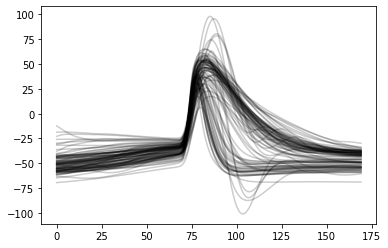

In [7]:
data_wave_FN = pd.read_pickle('D:/CurrentClamp/waveforms.pkl')
print(len(data_wave_FN))
data_wave_FN.exp_name = [i[:-3] for i in data_wave_FN.exp_name]
fig = plt.Figure(figsize=[10,10])
plt.plot(np.vstack(data_wave_FN['waveforms']).T,c='k',alpha=0.2)
plt.show()


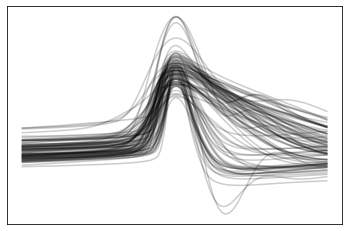

In [8]:
data_wave_CC = pd.read_pickle('D:/CurrentClamp/CC_waveforms.pkl')
data_wave_CC.columns = ['waveforms', 'trial','exp_name']
data_wave_CC.exp_name = [i[:-3] for i in data_wave_CC.exp_name]
data_wave_CC  = data_wave_CC[data_wave_CC.exp_name.isin(data_wave_FN.exp_name)]
data_wave_CC = data_wave_CC.drop_duplicates('exp_name')
fig = plt.Figure(figsize=[10,10])
plt.plot(np.arange(0,120/20,1/20),np.vstack(data_wave_CC['waveforms']).T,c='k',alpha=0.2)
# plt.xlabel('ms')
plt.xticks([])
plt.yticks([])

plt.show()

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


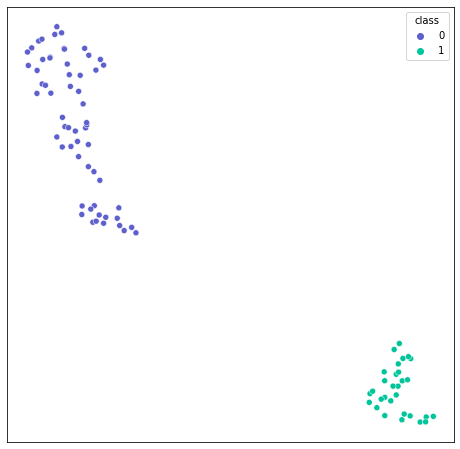

In [9]:
waves = normalize(np.vstack(data_wave_CC['waveforms']))
lables_wave,mapper,reducer = plot_UMAP_clusters_single(waves,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 0.1,
                          c_list =CUSTOM_PAL_SORT_3,
                          )

0 60


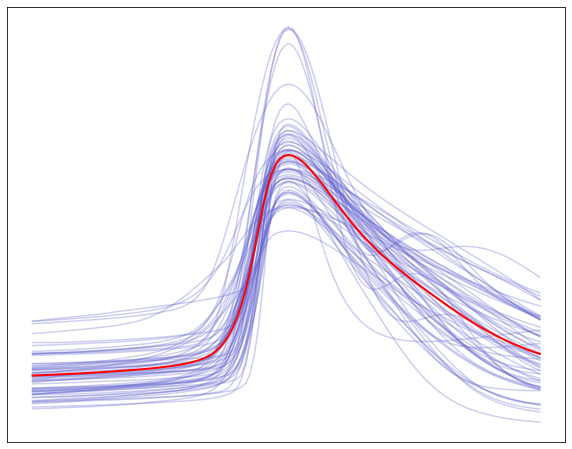

1 30


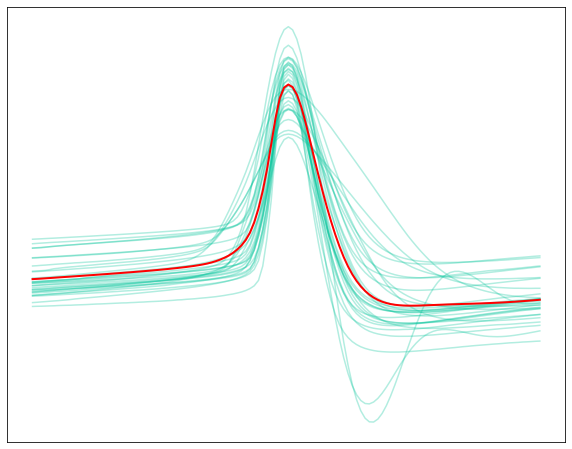

In [10]:
data_wave_CC['waveform_lables'] = lables_wave
for i in set(data_wave_CC['waveform_lables']):
    plt.figure(figsize=[10,8])
    print(i,len(np.vstack(data_wave_CC[data_wave_CC['waveform_lables']==i]['waveforms'])))
    plt.plot(np.vstack(data_wave_CC[data_wave_CC['waveform_lables']==i]['waveforms']).T,c=CUSTOM_PAL_SORT_3[i],alpha=0.3)
    plt.plot(np.mean(np.vstack(data_wave_CC[data_wave_CC['waveform_lables']==i]['waveforms']).T,axis=1),c='red',alpha=1,linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.show()


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


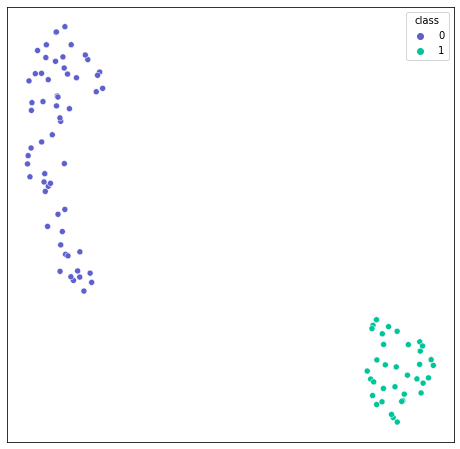

In [11]:
waves = normalize(np.vstack(data_wave_FN['waveforms']))
lables_wave_FN,mapper,reducer = plot_UMAP_clusters_single(waves,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 0.1,
                          c_list =CUSTOM_PAL_SORT_3,
                          )

0 59


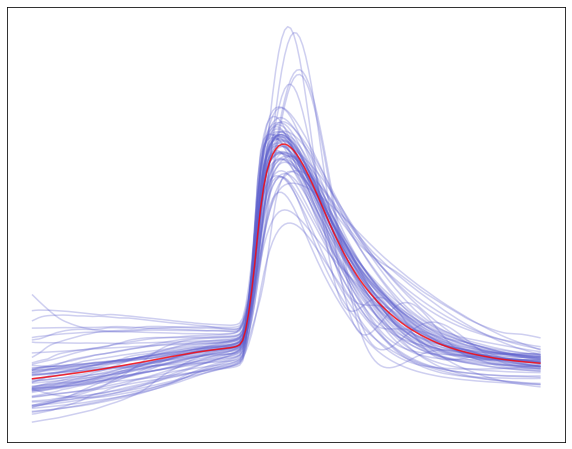

1 36


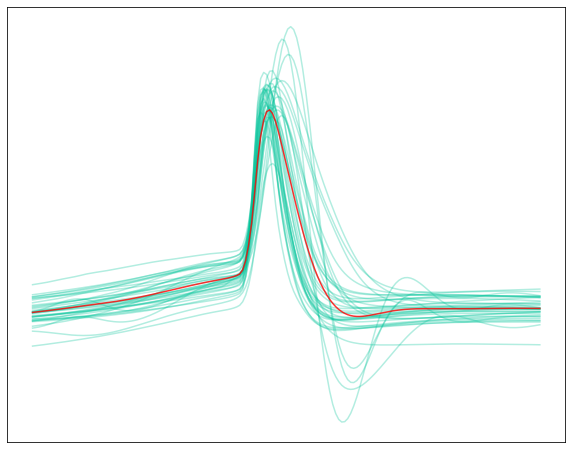

In [12]:
data_wave_FN['waveform_lables'] = lables_wave_FN
for i in set(data_wave_FN['waveform_lables']):
    plt.figure(figsize=[10,8])
    print(i,len(np.vstack(data_wave_FN[data_wave_FN['waveform_lables']==i]['waveforms'])))
    plt.plot(np.vstack(data_wave_FN[data_wave_FN['waveform_lables']==i]['waveforms']).T,c=CUSTOM_PAL_SORT_3[i],alpha=0.3)
    plt.plot(np.mean(np.vstack(data_wave_FN[data_wave_FN['waveform_lables']==i]['waveforms']).T,axis=1),c='red',alpha=0.8)

    plt.xticks([])
    plt.yticks([])
    plt.show()


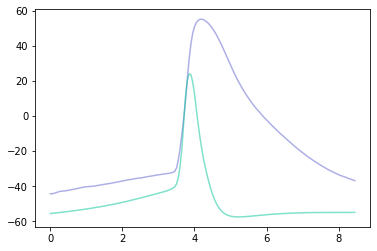

In [13]:
data_wave_FN['waveform_lables'] = lables_wave_FN

plt.plot(np.arange(0,len(np.mean(np.vstack(data_wave_FN[data_wave_FN['waveform_lables']==0]['waveforms']),axis=0))/20,1/20),np.vstack(data_wave_FN[data_wave_FN['waveform_lables']==0]['waveforms'])[10],c=CUSTOM_PAL_SORT_3[0],alpha=0.5)
plt.plot(np.arange(0,len(np.mean(np.vstack(data_wave_FN[data_wave_FN['waveform_lables']==1]['waveforms']),axis=0))/20,1/20),np.vstack(data_wave_FN[data_wave_FN['waveform_lables']==1]['waveforms'])[10],c=CUSTOM_PAL_SORT_3[1],alpha=0.5)


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


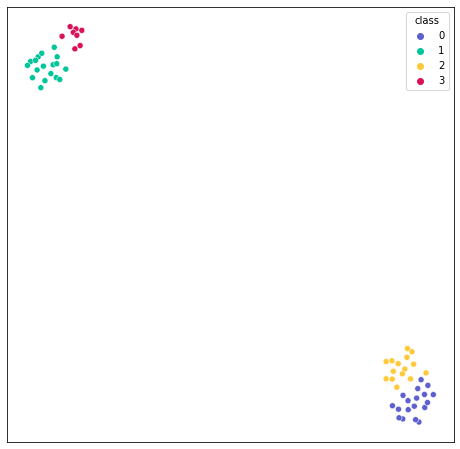

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


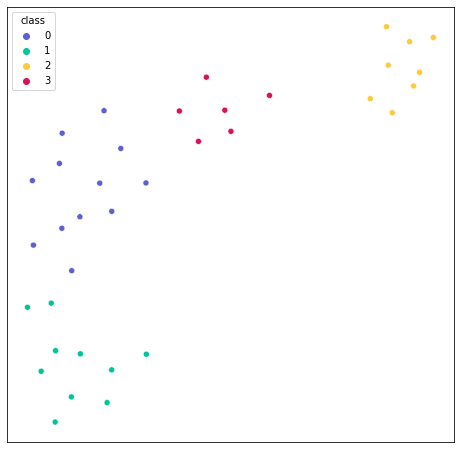

In [14]:
stas = pd.read_pickle("D:/CurrentClamp/all_stas.pkl")
stas[stas.cond.isin(['ACSF','aCSF'])]
# np.unique(stas.cond,return_counts=True)
stas['lables_wave'] = lables_wave_FN
sta_norm_exc = normalize(np.vstack(stas[stas.lables_wave==0]['sta']))
sta_norm_inh = normalize(np.vstack(stas[stas.lables_wave==1]['sta']))
lables_sta_exc,mapper,reducer = plot_UMAP_clusters_single(sta_norm_exc,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list =CUSTOM_PAL_SORT_3,
                          )
lables_sta_inh,mapper,reducer = plot_UMAP_clusters_single(sta_norm_inh,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list =CUSTOM_PAL_SORT_3,
                          )

0 59


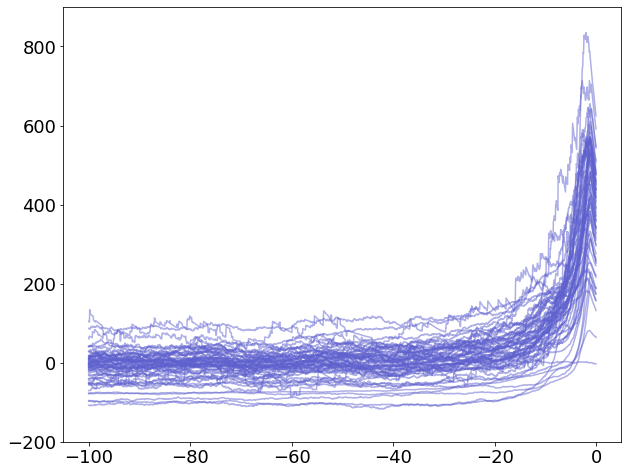

1 36


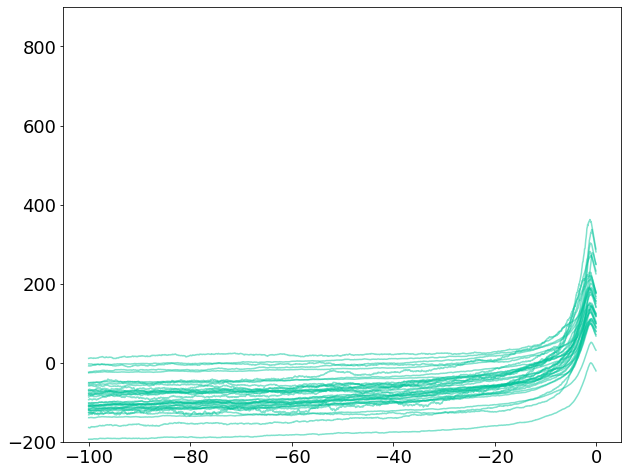

In [15]:
for i in set(stas['lables_wave']):
    plt.figure(figsize=[10,8])
    print(i,len(np.vstack(stas[stas['lables_wave']==i]['sta'])))
    plt.rcParams.update({'font.size': 18})
    plt.plot(np.arange(-100,0,1/20),np.vstack(stas[stas['lables_wave']==i]['sta']).T,c=CUSTOM_PAL_SORT_3[i],alpha=0.5)
    plt.ylim([-200,900])
    # plt.xticks([])
    # plt.yticks([])
    plt.show()

In [16]:
sta_exc = stas[stas.lables_wave==0]
sta_exc['lv_lables']= lables_sta_exc
sta_inh = stas[stas.lables_wave==1]
sta_inh['lv_lables']= lables_sta_inh

<ipython-input-16-69cbd440c243>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sta_exc['lv_lables']= lables_sta_exc
<ipython-input-16-69cbd440c243>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sta_inh['lv_lables']= lables_sta_inh


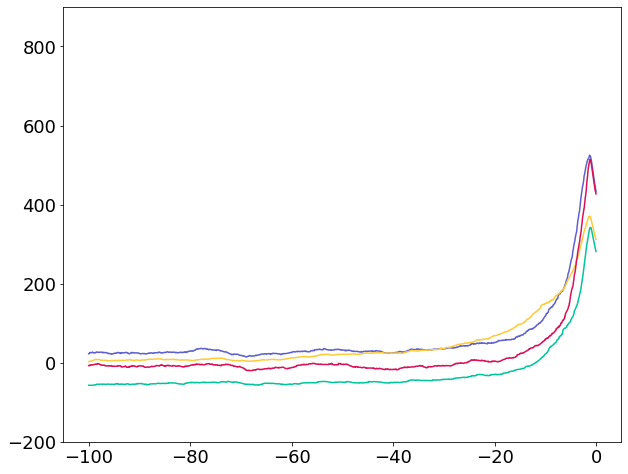

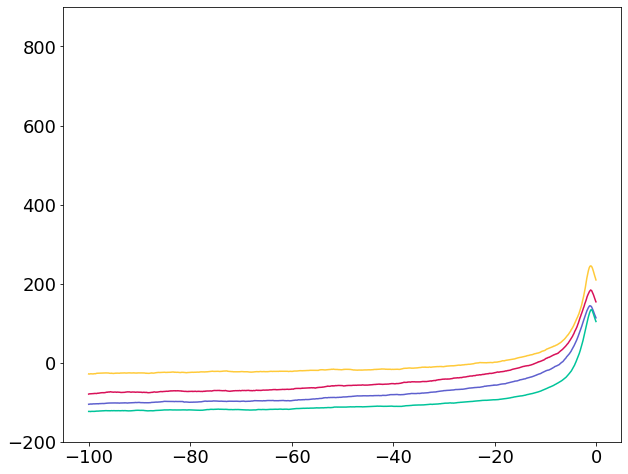

In [33]:
plt.figure(figsize=[10,8])

for i in set(sta_exc['lv_lables']):
    plt.plot(np.arange(-100,0,1/20),np.mean(np.vstack(sta_exc[sta_exc['lv_lables']==i]['sta']).T,axis=1),c=CUSTOM_PAL_SORT_3[i])
    plt.ylim([-200,900])
    # plt.xticks([])
    # plt.yticks([])
plt.show()
plt.figure(figsize=[10,8])
for i in set(sta_inh['lv_lables']):
    plt.plot(np.arange(-100,0,1/20),np.mean(np.vstack(sta_inh[sta_inh['lv_lables']==i]['sta']).T,axis=1),c=CUSTOM_PAL_SORT_3[i])
    plt.ylim([-200,900])
    # plt.xticks([])
    # plt.yticks([])
plt.show()

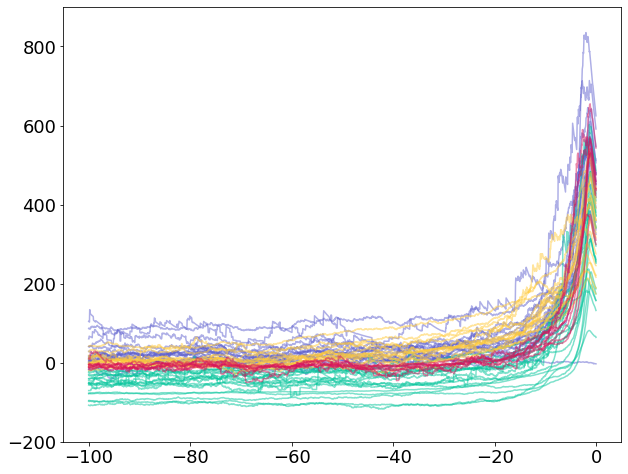

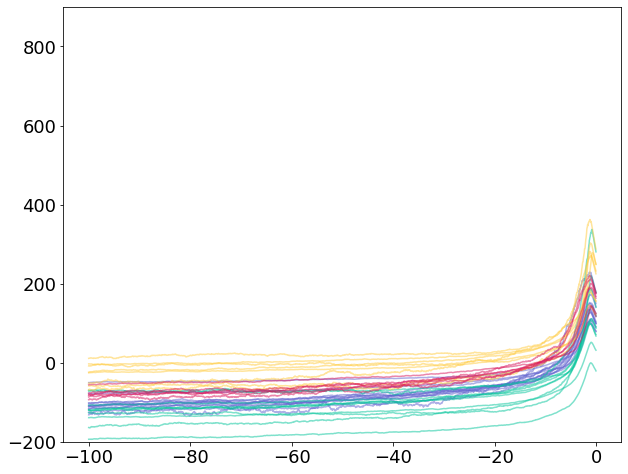

In [34]:
plt.figure(figsize=[10,8])

for i in set(sta_exc['lv_lables']):
    plt.plot(np.arange(-100,0,1/20),np.vstack(sta_exc[sta_exc['lv_lables']==i]['sta']).T,c=CUSTOM_PAL_SORT_3[i],alpha=0.5)
    plt.ylim([-200,900])
    # plt.xticks([])
    # plt.yticks([])
plt.show()
plt.figure(figsize=[10,8])
for i in set(sta_inh['lv_lables']):
    plt.plot(np.arange(-100,0,1/20),np.vstack(sta_inh[sta_inh['lv_lables']==i]['sta']).T,c=CUSTOM_PAL_SORT_3[i],alpha=0.5)
    plt.ylim([-200,900])
    # plt.xticks([])
    # plt.yticks([])
plt.show()

In [33]:
data_all_CC= data_wave_CC
data_all_FN= data_wave_FN[data_wave_FN.exp_name.isin(data_wave_CC.exp_name)]
data_CC_waveforms_exc = data_all_CC[data_all_CC.waveform_lables == 0] 
data_CC_waveforms_exc = data_CC_waveforms_exc.sort_values('exp_name') 
data_CC_waveforms_inh = data_all_CC[data_all_CC.waveform_lables == 1]
data_CC_waveforms_inh = data_CC_waveforms_inh.sort_values('exp_name') 
data_FN_waveforms_exc = data_all_FN[data_all_FN.waveform_lables == 0]
data_FN_waveforms_inh = data_all_FN[data_all_FN.waveform_lables == 1]


use random seed: 42
Shape of Raw data
Dataset 0: (58, 170)
Dataset 1: (60, 120)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/500] err:1.1490 alpha:0.6482
epoch:[200/500] err:1.0469 alpha:0.6741
epoch:[300/500] err:0.9730 alpha:0.6866
epoch:[400/500] err:0.9360 alpha:0.6950
epoch:[500/500] err:0.9137 alpha:0.7012
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:0.587445, align_loss:0.086847
epoch:[20/100]: loss:0.517897, align_loss:0.083267
epoch:[30/100]: loss:0.509590, align_loss:0.080730
epoch:[40/100]: loss:0.438039, align_loss:0.082095
epoch:[50/100]: loss:0.446749, align_loss:0.077409
epoch:[60/100]: loss:0.466604, align_loss:0.071908
epoch:[70/100]: loss:0.459729, align_loss:0.067644
epoch:[80/100]: loss:0.406503, align_loss:0.074194
epoch:[90/100]: loss:0.403182, align_loss:0.069674
epoch:[100/100]: loss:0.481489, align_loss:0.071104
Done
----------------

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\unioncom\visualization.py:127: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[i][:,0], embedding[i][:,1], c=color[i], s=5., alpha=0.8)


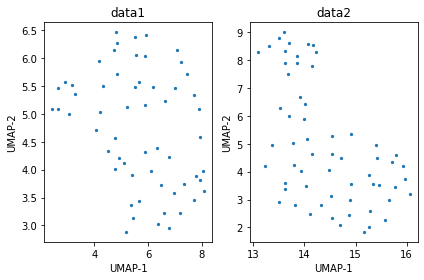

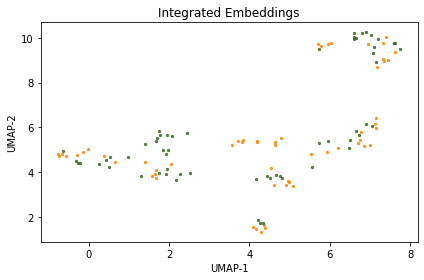

In [34]:
from unioncom import UnionCom
# import numpy as np

data_scaler = StandardScaler()

data1_exc = data_FN_waveforms_exc['waveforms']
data1_exc = data_scaler.fit_transform(np.vstack(data1_exc.to_numpy()))

data2_exc = data_CC_waveforms_exc['waveforms']
data2_exc = data_scaler.fit_transform(np.vstack(data2_exc.to_numpy()))

uc = UnionCom.UnionCom(project_mode='tsne',output_dim=20,manual_seed=42,epoch_pd=500, epoch_DNN=100)
integrated_data = uc.fit_transform(dataset=[data1_exc,data2_exc])
# uc.test_LabelTA(integrated_data, [labels_fn_exc,labels_cc_exc])
# uc.Visualize([data1,data2], integrated_data, mode='UMAP') # without datatype
uc.Visualize([data1_exc,data2_exc], integrated_data,mode='UMAP') # without datatype

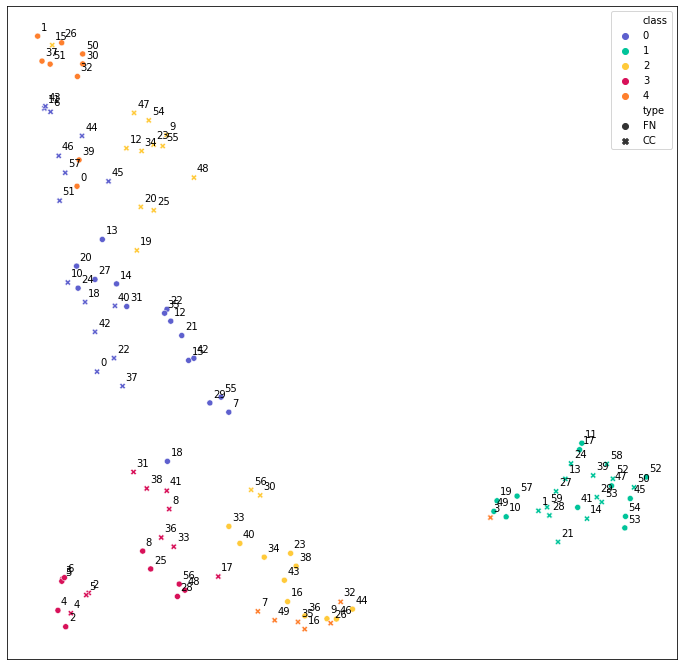

In [35]:

data_umapFN = integrated_data[0]
data_umapCC = integrated_data[1]
data_umap_combined = np.vstack([integrated_data[0],integrated_data[1]])


fig = plt.figure(figsize=[12,12])
ax12d = fig.add_subplot(1,1,1)
random_state =42
neighbours = 20
dist = .1
res_louvain = 1.

reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)

mapperFN = reducer.fit(data_umapFN)
louvain = Louvain(resolution=res_louvain,random_state=random_state)
adjacency = mapperFN.graph_
labels_fn_red_exc = louvain.fit_predict(adjacency)

mapperCC = reducer.fit(data_umapCC)
louvain = Louvain(resolution=res_louvain,random_state=random_state)
adjacency = mapperCC.graph_
labels_cc_red_exc = louvain.fit_predict(adjacency)

clusterable_embedding2d = reducer.fit_transform(data_umap_combined)    

labels_fn_exc,labels_cc_exc = data_FN_waveforms_exc['waveform_lables'],data_CC_waveforms_exc['waveform_lables']
df_2d_exc_fn = {'UMAP1':clusterable_embedding2d[:, 0],
            'UMAP2':clusterable_embedding2d[:, 1],
            'class':np.concatenate([labels_fn_red_exc,labels_cc_red_exc]),
            'type':np.concatenate([np.repeat('FN',len(labels_fn_red_exc)),np.repeat('CC',len(labels_cc_red_exc))])}


ax12d.set_xticks([])
ax12d.set_yticks([])
markers = {'CC':'*','FN':'o'}
# sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
sns.scatterplot(data=df_2d_exc_fn,x='UMAP1',y='UMAP2',hue='class',style='type',palette=CUSTOM_PAL_SORT_3[:max(len(set(labels_fn_red_exc)),len(set(labels_cc_red_exc)))],ax=ax12d)
for i in range(len(clusterable_embedding2d)):
    if i<len(data_umapFN):
        plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))
    else:
        plt.annotate(str(i-len(data_umapFN)),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))


# ax12d.set_title('UMAP clusters for excitatory neurons 2D')
ax12d.legend()


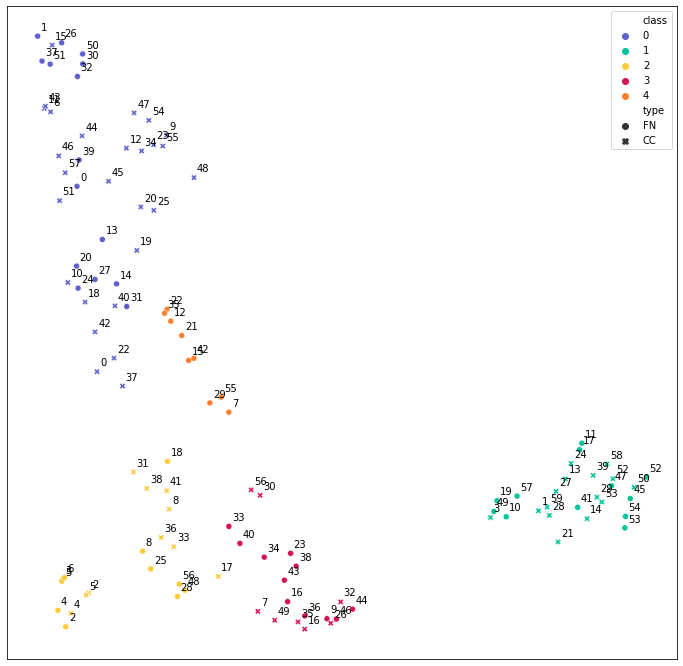

In [38]:

data_umapFN = integrated_data[0]
data_umapCC = integrated_data[1]
data_umap_combined = np.vstack([integrated_data[0],integrated_data[1]])


fig = plt.figure(figsize=[12,12])
ax12d = fig.add_subplot(1,1,1)
random_state =42
neighbours = 20
dist = .1
res_louvain = .6

reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)

mapperFN = reducer.fit(data_umap_combined)
louvain = Louvain(resolution=res_louvain,random_state=random_state)
adjacency = mapperFN.graph_
labels_fn_red_inh = louvain.fit_predict(adjacency)

clusterable_embedding2d = reducer.fit_transform(data_umap_combined)    


df_2d_exc_fn = {'UMAP1':clusterable_embedding2d[:, 0],
            'UMAP2':clusterable_embedding2d[:, 1],
            'class':labels_fn_red_inh,
            'type':np.concatenate([np.repeat('FN',len(data_umapFN)),np.repeat('CC',len(data_umapCC))])}


ax12d.set_xticks([])
ax12d.set_yticks([])
markers = {'CC':'*','FN':'o'}
# sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
sns.scatterplot(data=df_2d_exc_fn,x='UMAP1',y='UMAP2',style='type',hue='class', palette=CUSTOM_PAL_SORT_3[:len(set(labels_fn_red_inh))],ax=ax12d) #,style='type',palette=CUSTOM_PAL_SORT_3[:len(set(labels_fn_red))],
for i in range(len(clusterable_embedding2d)):
    if i<len(data_umapFN):
        plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))
    else:
        plt.annotate(str(i-len(data_umapFN)),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))


# ax12d.set_title('UMAP clusters for excitatory neurons 2D')
ax12d.legend()


In [39]:
df = pd.DataFrame(columns=['FN_ID','CC_ID','Cluster_ID_FN','Cluster_ID_CC'])
df = np.nan*(df['FN_ID'] )
df['FN_ID'] = np.arange(1,len(data_umapFN)+1)
df['CC_ID'] = np.arange(1,len(data_umapCC)+1)
df['Cluster_ID_FN'] = labels_fn_red[:len(data_umapFN)]
df['Cluster_ID_CC'] = labels_fn_red[len(data_umapFN):]

np.unique(df['Cluster_ID_CC'][:-2] -df['Cluster_ID_FN']  ,return_counts=True)

NameError: name 'labels_fn_red' is not defined

Index(['waveforms', 'cond', 'exp_name', 'trial', 'waveform_lables'], dtype='object')
Index(['waveforms', 'trial', 'exp_name', 'waveform_lables'], dtype='object')


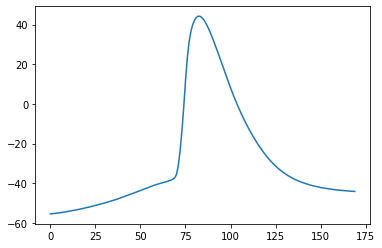

In [41]:
print(data_FN_waveforms_exc.columns)
print(data_CC_waveforms_exc.columns)
df_all_wave = pd.concat([data_FN_waveforms_exc[data_CC_waveforms_exc.columns],data_CC_waveforms_exc])
df_all_wave['prot'] = np.concatenate((np.repeat('FN',len(data_FN_waveforms_exc)),np.repeat('CC',len(data_CC_waveforms_exc))))
df_all_wave['comb_lables'] = labels_fn_red_inh
FN = df_all_wave[df_all_wave.prot=='FN']
CC = df_all_wave[df_all_wave.prot=='CC']
plt.plot((np.mean(FN[FN.comb_lables==0]['waveforms'])))
# plt.plot(np.mean(CC[CC.comb_lables==0]['waveforms']))

use random seed: 42
Shape of Raw data
Dataset 0: (30, 170)
Dataset 1: (30, 120)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/500] err:1.2839 alpha:0.6971
epoch:[200/500] err:1.1973 alpha:0.7534
epoch:[300/500] err:1.0693 alpha:0.7970
epoch:[400/500] err:0.8937 alpha:0.8432
epoch:[500/500] err:0.7888 alpha:0.8742
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:0.178674, align_loss:0.021119
epoch:[20/100]: loss:0.109745, align_loss:0.008252
epoch:[30/100]: loss:0.082291, align_loss:0.003989
epoch:[40/100]: loss:0.072400, align_loss:0.002877
epoch:[50/100]: loss:0.082428, align_loss:0.001866
epoch:[60/100]: loss:0.067633, align_loss:0.001560
epoch:[70/100]: loss:0.071544, align_loss:0.001295
epoch:[80/100]: loss:0.092951, align_loss:0.001011
epoch:[90/100]: loss:0.080584, align_loss:0.000894
epoch:[100/100]: loss:0.071753, align_loss:0.000818
Done
----------------

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\unioncom\visualization.py:127: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[i][:,0], embedding[i][:,1], c=color[i], s=5., alpha=0.8)


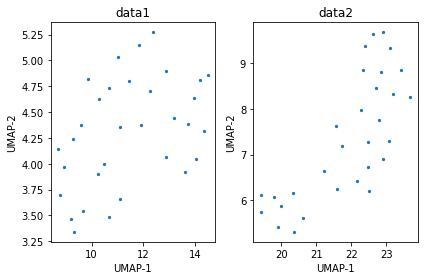

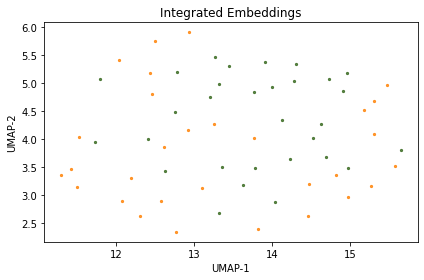

In [22]:
from unioncom import UnionCom
# import numpy as np

data_scaler = StandardScaler()

data1_inh = data_FN_waveforms_inh['waveforms']
data1_inh = data_scaler.fit_transform(np.vstack(data1_inh.to_numpy()))

data2_inh = data_CC_waveforms_inh['waveforms']
data2_inh = data_scaler.fit_transform(np.vstack(data2_inh.to_numpy()))


uc = UnionCom.UnionCom(project_mode='tsne',output_dim=20,manual_seed=42,epoch_pd=500,epoch_DNN=100)
integrated_data = uc.fit_transform(dataset=[data1_inh[:30],data2_inh])
uc.Visualize([data1_inh,data2_inh], integrated_data,mode='UMAP') # without datatype

In [54]:

def find_optimum_res(data):
    resolution_list = np.linspace(0,5,11)
    modularity_dict = {}
    n_clusts_dict = {}
    #Louvain Clustering Parameters
    RESOLUTION = 1.5
    random_state = 42
    full_data = data
    # BLUE COLOR
    BlueCol = '\033[94m'
    subsets=[100]
    import random 
    for res in resolution_list:
        print("\n" + BlueCol + str(res))
        for frac in subsets:
            rand_list = []
            n_clusts = []
            for i in list(range(1,25)):
                reducer_rand_test = umap.UMAP(n_neighbors = 20, 
                                        min_dist=0.1, 
                                        random_state=random.randint(1,100000))
                rand_data = np.vstack(np.random.permutation(full_data))
                mapper = reducer_rand_test.fit(rand_data)
                embedding_rand_test = reducer_rand_test.transform(rand_data)

                umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
                louvain = Louvain(resolution=res,random_state=random_state)
                adjacency = mapper.graph_
                labels_exc = louvain.fit_predict(adjacency)
                clustering_solution = labels_exc
                modularity= get_modularity(adjacency,labels_exc)
                rand_list.append(modularity)
                n_clusts.append(len(set(clustering_solution)))
            modularity_dict.update({str(res): rand_list})
            n_clusts_dict.update({str(res): n_clusts})


    resolution_list = np.linspace(0,5,11)

    # if 'n_clusts_dict' not in list(locals().keys()):
    #     n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

    # if 'modularity_dict' not in list(locals().keys()):
    #     modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

    avg_n_clusts = []
    for k in list(n_clusts_dict.keys()):
        avg_n_clusts.append(np.mean(n_clusts_dict[k]))
        
    std_n_clusts = []
    for k in list(n_clusts_dict.keys()):
        std_n_clusts.append(np.std(n_clusts_dict[k]))
        
    std_modularity = []
    for k in list(modularity_dict.keys()):
        std_modularity.append(np.std(modularity_dict[k]))
        
    avg_modularity = []
    for k in list(modularity_dict.keys()):
        avg_modularity.append(np.mean(modularity_dict[k]))

    f, ax1 = plt.subplots(figsize=[3,2.5])

    ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
                c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
                linewidth=1, markeredgewidth=1)
    ax1.set_ylabel('Modularity Score')
    ax1.set_xlabel('Resolution Parameter',fontsize=12)
    ax1.set_xlim([0,8])
    ax1.set_xticks([0,2,4,6,8])
    ax1.yaxis.label.set_color('#5c95ff')
    ax1.tick_params(axis='y',colors='#5c95ff')
    ax1.set_ylim(0,1.0)
    ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    # ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_color('#f87575')
    ax1.spines['left'].set_color('#5c95ff')

    ax2 = ax1.twinx()
    ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
                c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
    ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
    # ax2.spines['left'].set_color('b')
    ax2.tick_params(axis='y',colors='#f87575')
    ax2.set_ylim([0,18])
    ax2.set_yticks([0,4,8,12,16]);
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_color('#f87575')
    ax2.spines['left'].set_color('#5c95ff')
    plt.show()

# find_optimum_res(data_wave['waveforms'])    

In [33]:
data_CC = pd.read_csv("D:/CurrentClamp/all_ephys_CC.csv")
data_CC[data_CC.columns[1:]].drop_duplicates('exp_name')

,current_at_first_spike,ap_count,fr,inst_fr,time_to_first_spike,mean_isi,max_isi,min_isi,median_isi,first_thr,...,median_width,max_width,min_width,first_amplitude,mean_amplitude,median_amplitude,max_amplitude,min_amplitude,trialnr,exp_name
0,5.821875e-11,5,0.010001,0.040195,-25.15,50.537500,74.30,8.80,59.525,-0.044906,...,1.650,1.90,1.55,0.093594,0.093594,0.093594,0.093594,0.093594,1.0,171222_NC_162
2,-2.336250e-10,5,0.010001,0.071984,-37.60,79.500000,184.60,5.85,63.775,-0.043437,...,1.200,1.25,1.15,0.095781,0.087375,0.087375,0.095781,0.078969,1.0,171222_NC_161
5,-5.640625e-11,18,0.036004,0.049504,107.95,26.838235,38.25,6.30,30.550,-0.032844,...,1.425,1.45,1.40,0.091500,0.090984,0.090984,0.091500,0.090469,1.0,171222_NC_160
8,5.390625e-11,12,0.024002,0.033502,-18.80,43.872727,56.65,6.50,47.650,-0.033219,...,1.400,1.45,1.40,0.092844,0.091708,0.091406,0.092844,0.090875,1.0,171220_NC_159
10,-1.575625e-10,11,0.022002,0.032208,0.95,48.790000,72.25,8.00,54.225,-0.039844,...,1.300,1.35,1.30,0.096313,0.096313,0.096313,0.096313,0.096313,1.0,171220_NC_158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,-5.786562e-10,7,0.014001,0.102768,-32.15,9.966667,11.05,7.10,10.600,-0.060187,...,0.550,0.60,0.45,0.098281,0.098281,0.098281,0.098281,0.098281,1.0,170518_NC_18
378,-2.287812e-10,2,0.004000,0.000996,956.50,1004.500000,1004.50,1004.50,1004.500,-0.057156,...,1.100,1.10,1.10,0.096875,0.096875,0.096875,0.096875,0.096875,1.0,170517_NC_17
381,1.023969e-09,33,0.066007,0.118277,-8.25,15.087500,33.35,5.00,7.450,NaN,...,1.200,1.25,1.15,0.140187,0.118487,0.117094,0.140187,0.104594,NaN,NaN
382,9.740313e-10,17,0.034003,0.049153,51.65,28.825000,39.70,5.05,32.450,-0.001969,...,1.200,1.30,1.10,0.131281,0.131281,0.131281,0.131281,0.131281,2.0,170202_NC_9


In [35]:
data_CC.exp_name

0      171222_NC_162
1      171222_NC_162
2      171222_NC_161
3      171222_NC_161
4      171222_NC_161
           ...      
382      170202_NC_9
383      170202_NC_9
384     170703_NC_38
385     170703_NC_38
386     170703_NC_38
Name: exp_name, Length: 387, dtype: object

In [45]:
data_CC = pd.read_csv("D:/CurrentClamp/all_ephys_CC.csv")
data_CC = data_CC[data_CC.columns[1:]] 
data_CC = data_CC.dropna()
data_CC = data_CC.drop_duplicates('exp_name')

data_CC = data_CC[data_CC.exp_name.isin(FN_LIST)]
data_CC = data_CC.sort_values('exp_name')


372     170615_NC_19
369     170616_NC_20
366     170620_NC_22
357     170626_NC_29
354     170627_NC_30
           ...      
10     171220_NC_158
8      171220_NC_159
5      171222_NC_160
2      171222_NC_161
0      171222_NC_162
Name: exp_name, Length: 90, dtype: object

In [50]:
data_CC.columns

Index(['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'max_isi', 'min_isi', 'median_isi',
       'first_thr', 'mean_thr', 'max_thr', 'min_thr', 'median_thr',
       'first_width', 'mean_width', 'median_width', 'max_width', 'min_width',
       'first_amplitude', 'mean_amplitude', 'median_amplitude',
       'max_amplitude', 'min_amplitude', 'trialnr', 'exp_name',
       'waveform_labels'],
      dtype='object')

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


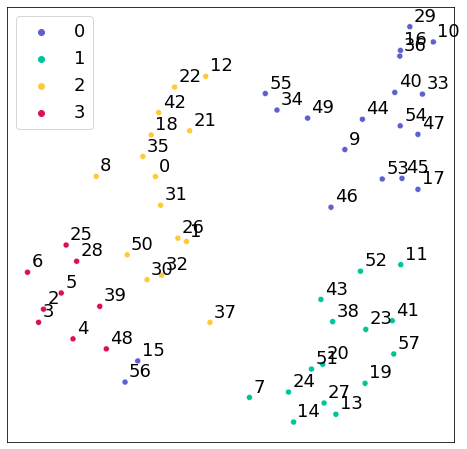

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


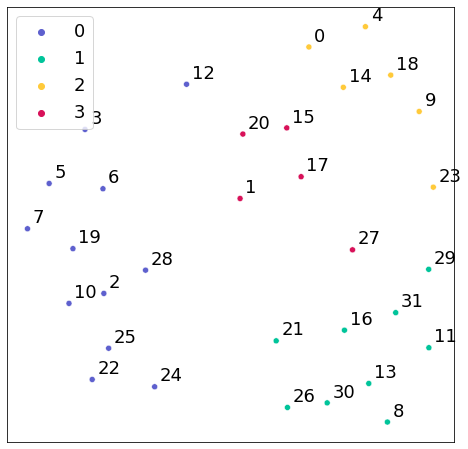

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


5


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


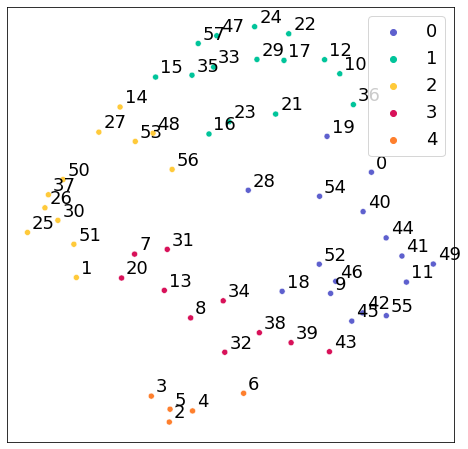

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


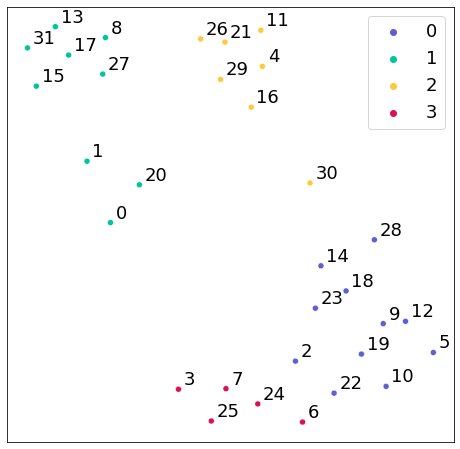

In [51]:
data_FN = pd.read_csv("D:/CurrentClamp/all_ephys_feats_FN.csv")
data_FN = data_FN[data_FN.columns[1:]] 
data_FN['waveform_labels'] = lables_wave_FN
FN_LIST = [i[:-3] for i in data_FN.exp_name]
data_FN.exp_name =FN_LIST 


data_CC = pd.read_csv("D:/CurrentClamp/all_ephys_CC.csv")
data_CC = data_CC[data_CC.columns[1:]] 
data_CC = data_CC.dropna()
data_CC = data_CC.drop_duplicates('exp_name')

data_CC = data_CC[data_CC.exp_name.isin(FN_LIST)]
data_CC = data_CC.sort_values('exp_name')
data_CC['waveform_labels'] = data_CC['exp_name'].map(data_FN.set_index('exp_name')['waveform_labels'])

data_FN = data_FN[data_FN.exp_name.isin(data_CC.exp_name)]

data_CC_exc =  data_CC[data_CC.waveform_labels ==0]
data_CC_inh =  data_CC[data_CC.waveform_labels ==1]

data_FN_exc = data_FN[data_FN.waveform_labels==0]
data_FN_inh = data_FN[data_FN.waveform_labels==1]

# print(np.unique(data_FN.waveform_labels,return_counts=True))
# print(np.unique(data_CC.waveform_labels,return_counts=True))

lables_fn_exc,mapper,reducer = plot_UMAP_clusters_single(data_FN_exc[data_FN_exc.columns[:-4]],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list = CUSTOM_PAL_SORT_3,
                          annotate=True,
                          save=True,
                          savepath='D:/exc_FN.png'
                          )

lables_fn_inh,mapper,reducer = plot_UMAP_clusters_single(data_FN_inh[data_FN_inh.columns[:-4]],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list = CUSTOM_PAL_SORT_3,
                          annotate=True,
                          save=True,
                          savepath='D:/inh_FN.png'
                          )
CC_cols = ['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'max_isi', 'min_isi', 'median_isi',
       'first_thr', 'mean_thr', 'max_thr', 'min_thr', 'median_thr',
       'first_width', 'mean_width', 'median_width', 'max_width', 'min_width',
       'first_amplitude', 'mean_amplitude', 'median_amplitude',
       'max_amplitude', 'min_amplitude']

lables_cc_exc,mapper,reducer = plot_UMAP_clusters_single(data_CC_exc[CC_cols],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list = CUSTOM_PAL_SORT_3,
                          annotate=True,
                          save=True,
                          savepath='D:/exc_CC.png'
                          )

lables_cc_inh,mapper,reducer = plot_UMAP_clusters_single(data_CC_inh[CC_cols],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list = CUSTOM_PAL_SORT_3,
                          annotate=True,
                          save=True,
                          savepath='D:/inh_CC.png'

                          )



0.0

0.5

1.0

1.5

2.0

2.5

3.0

3.5

4.0

4.5

5.0


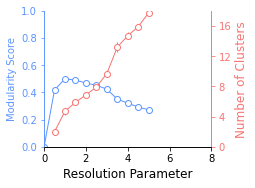

In [62]:
find_optimum_res(data_CC_exc[CC_cols])    

In [52]:
data_FN_exc['lables_lv'] = lables_fn_exc
data_FN_inh['lables_lv'] = lables_fn_inh
data_CC_exc['lables_lv'] = lables_cc_exc
data_CC_inh['lables_lv'] = lables_cc_inh


<ipython-input-52-7011fe325fd5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_FN_exc['lables_lv'] = lables_fn_exc
<ipython-input-52-7011fe325fd5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_FN_inh['lables_lv'] = lables_fn_inh
<ipython-input-52-7011fe325fd5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

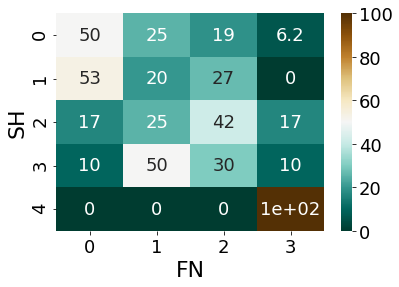

In [56]:

df = pd.DataFrame(columns=['exp_name','labels_CC','labels_FN'])
df['exp_name'] = data_CC_exc.exp_name

df['labels_CC'] = np.array(data_CC_exc.lables_lv)
df['labels_FN'] = np.array(data_FN_exc.lables_lv)

sta_mat = np.zeros((len(set(df['labels_CC'])),len(set(df['labels_FN']))))
for i in np.unique(df.labels_CC):
    data_ = np.unique(df[df.labels_CC==i]['labels_FN'],return_counts=True)
    sta_mat[i,data_[0]] =(data_[1]/np.sum(data_[1]))*100 
sns.heatmap(sta_mat,cmap='BrBG_r',annot=True)   
plt.xlabel('FN',fontsize=22)
plt.ylabel('SH',fontsize=22)
plt.savefig('D:/exc_correspondence.png',dpi=200,bbox_inches = "tight")


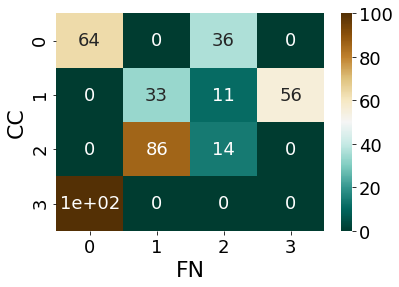

In [57]:

df = pd.DataFrame(columns=['exp_name','labels_CC','labels_FN'])
df['exp_name'] = data_CC_inh.exp_name

df['labels_CC'] = np.array(data_CC_inh.lables_lv)
df['labels_FN'] = np.array(data_FN_inh.lables_lv)

sta_mat = np.zeros((len(set(df['labels_CC'])),len(set(df['labels_FN']))))
for i in np.unique(df.labels_CC):
    data_ = np.unique(df[df.labels_CC==i]['labels_FN'],return_counts=True)
    sta_mat[i,data_[0]] =(data_[1]/np.sum(data_[1]))*100  
sns.heatmap(sta_mat,cmap='BrBG_r',annot=True)   
plt.xlabel('FN',fontsize=22)
plt.ylabel('CC',fontsize=22)
plt.savefig('D:/inh_correspondence.png',dpi=200,bbox_inches = "tight")


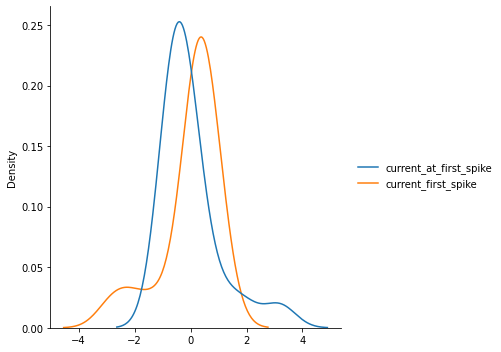

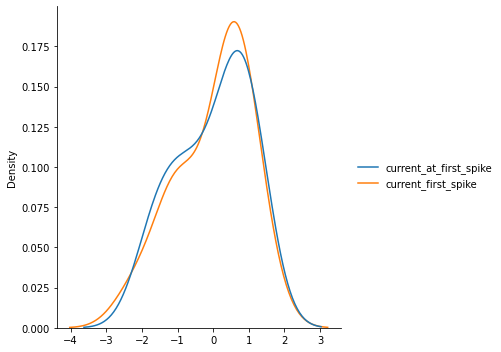

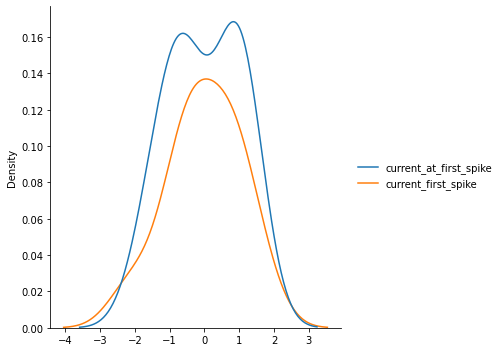

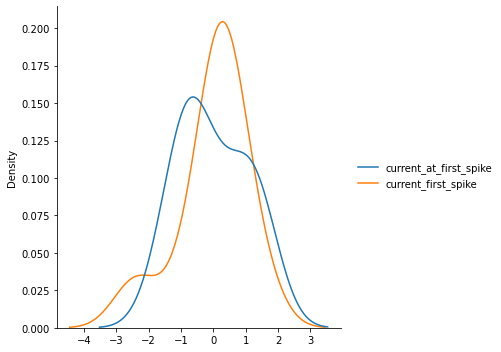

In [62]:
def z_score(data):
    return (data-np.mean(data))/np.std(data)

for i in set(data_FN_exc.lables_lv):
    sns.displot([z_score(data_FN_exc[data_FN_exc.lables_lv==i]['current_at_first_spike']),z_score(data_CC_exc[data_CC_exc.lables_lv==i]['current_first_spike'])],kind='kde')
    plt.show()

In [83]:
FN_feat  = ['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',]

CC_feat  = ['current_first_spike', 'ap_count', 'abs_firing_rate',
       'inst_firing_rate', 'time_to_first_spike', 'mean_isi','median_isi', 'max_isi',
       'min_isi',  'first_thrs', 'mean_thrs','median_thrs', 'max_thrs',
       'min_thrs', 'mean_hwidths',
       'median_hwidths', 'max_hwidths', 'min_hwidths', 'mean_amp',
       'median_amp', 'max_amp', 'min_amp']

df_FN_EX1 = data_FN_exc[data_FN_exc.lables_lv==0]
df_FN_EX2 = data_FN_exc[data_FN_exc.lables_lv==1]
df_FN_EX3 = data_FN_exc[data_FN_exc.lables_lv==2]
df_FN_EX4 = data_FN_exc[data_FN_exc.lables_lv==3]

df_CC_EX1 = data_CC_exc[data_CC_exc.lables_lv==0]
df_CC_EX2 = data_CC_exc[data_CC_exc.lables_lv==1]
df_CC_EX3 = data_CC_exc[data_CC_exc.lables_lv==2]
df_CC_EX4 = data_CC_exc[data_CC_exc.lables_lv==3]

df_FN_IN1 = data_FN_inh[data_FN_inh.lables_lv==0]
df_FN_IN2 = data_FN_inh[data_FN_inh.lables_lv==1]
df_FN_IN3 = data_FN_inh[data_FN_inh.lables_lv==2]
df_FN_IN4 = data_FN_inh[data_FN_inh.lables_lv==3]

df_CC_IN1 = data_CC_inh[data_CC_inh.lables_lv==0]
df_CC_IN2 = data_CC_inh[data_CC_inh.lables_lv==1]
df_CC_IN3 = data_CC_inh[data_CC_inh.lables_lv==2]
df_CC_IN4 = data_CC_inh[data_CC_inh.lables_lv==3]

from scipy.stats import wasserstein_distance
def return_wasserstein_distance(data_FN_exc,data_CC_exc,CC_feat,FN_feat):
       dist_mat  = []
       for i in set(data_FN_exc.lables_lv):
              temp = []
              for j in set(data_CC_exc.lables_lv):
                     # print(i,j)
                     temp.append(wasserstein_distance(z_score(data_CC_exc[data_CC_exc.lables_lv==j][CC_feat]),z_score(data_FN_exc[data_FN_exc.lables_lv==i][FN_feat])))
              dist_mat.append(temp)      
       return dist_mat        

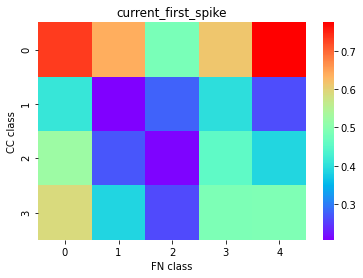

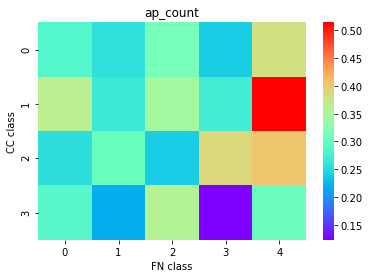

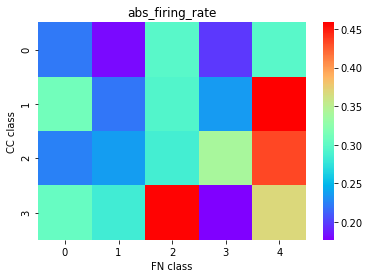

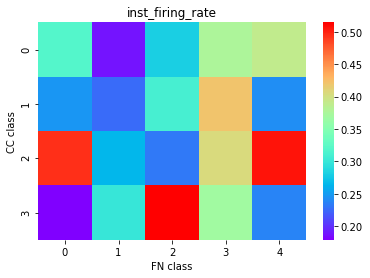

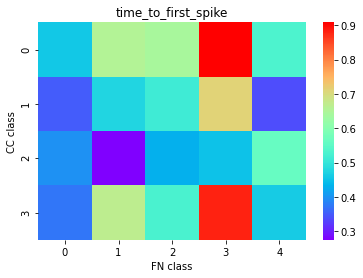

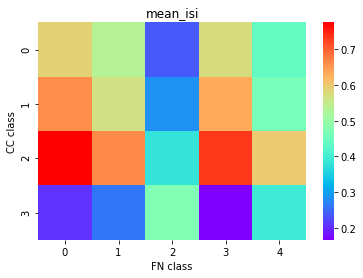

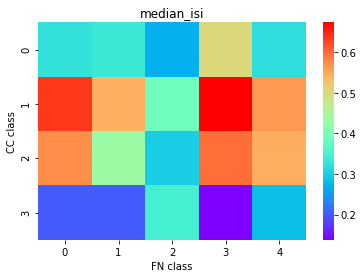

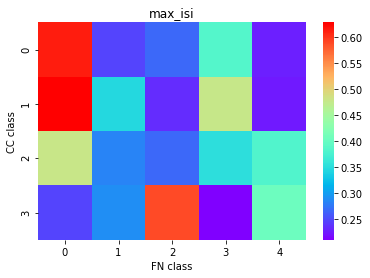

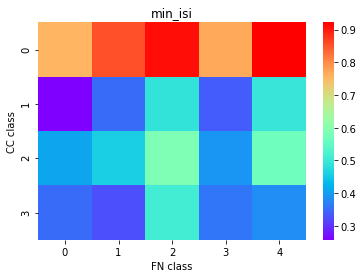

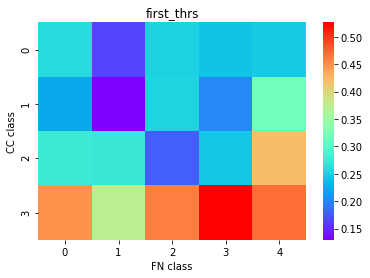

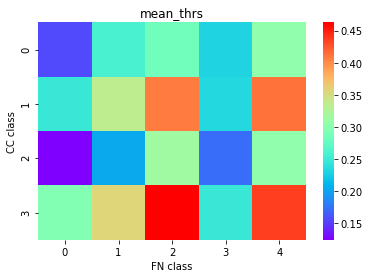

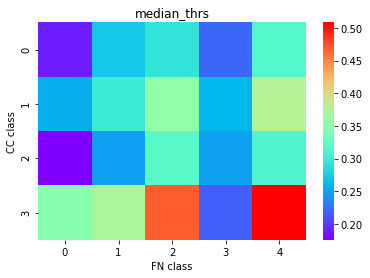

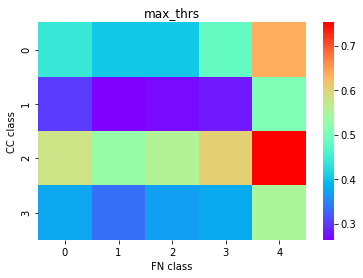

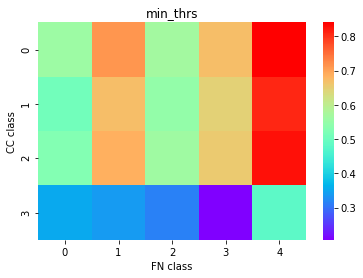

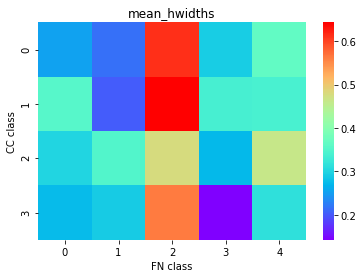

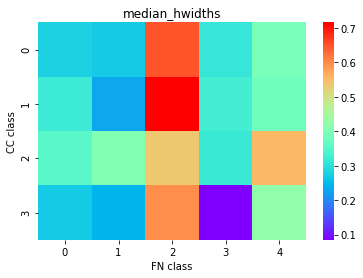

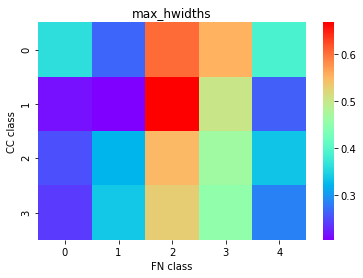

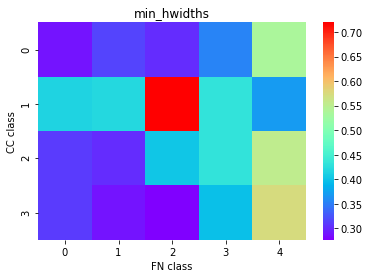

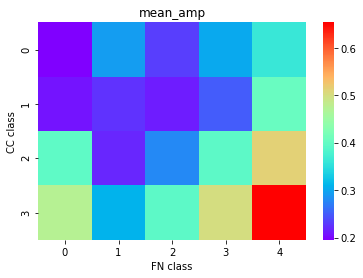

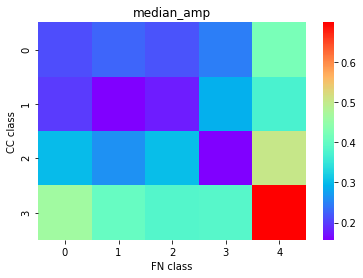

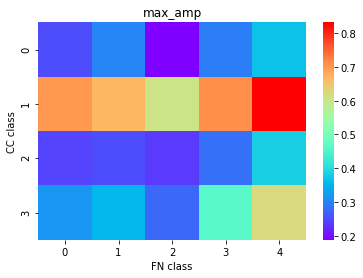

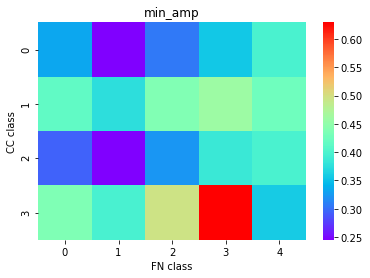

In [84]:
dist_all_exc = np.zeros((len(set(data_FN_exc.lables_lv)),len(set(data_CC_exc.lables_lv))))
for i in range(len(CC_feat)):
    dist_all_exc+=return_wasserstein_distance(data_FN_exc,data_CC_exc,CC_feat[i],FN_feat[i])
    sns.heatmap(return_wasserstein_distance(data_FN_exc,data_CC_exc,CC_feat[i],FN_feat[i]),cmap='rainbow')
    plt.ylabel('CC class')
    plt.xlabel('FN class')
    plt.title(CC_feat[i])
    plt.show()


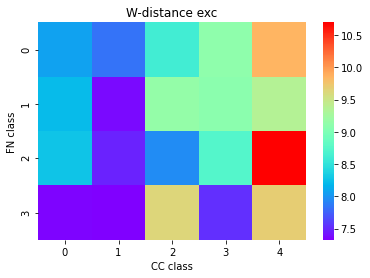

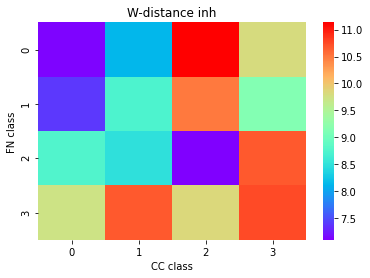

In [87]:
sns.heatmap(dist_all_exc,cmap='rainbow')
plt.ylabel('FN class')
plt.xlabel('CC class')
plt.title('W-distance exc')   
plt.show()
sns.heatmap(dist_all_inh,cmap='rainbow')
plt.ylabel('FN class')
plt.xlabel('CC class')
plt.title('W-distance inh')   
plt.show()
# sns.heatmap(dist_all_inh)

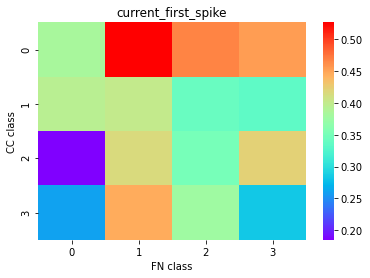

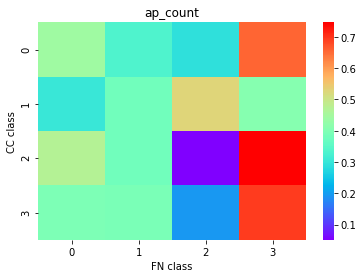

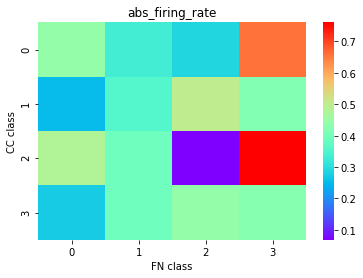

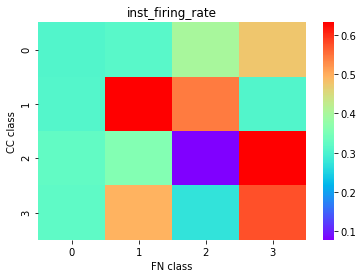

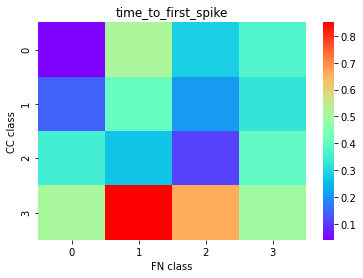

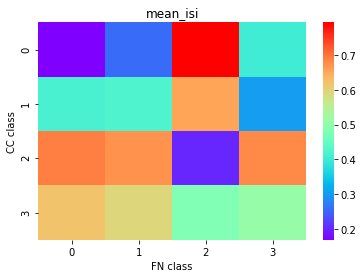

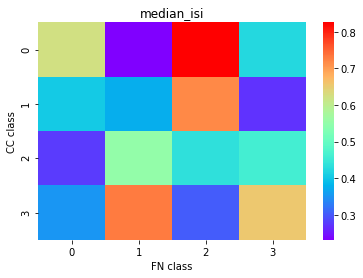

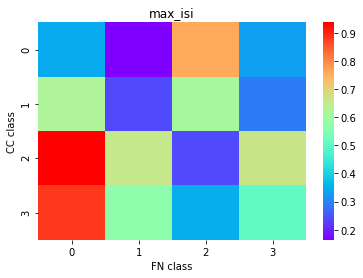

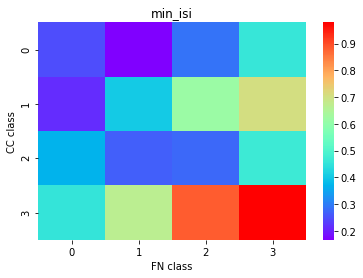

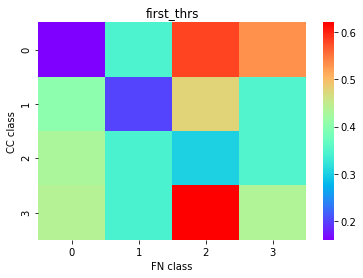

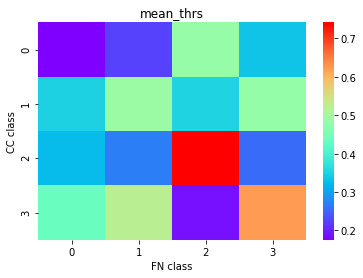

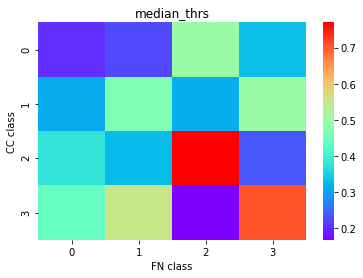

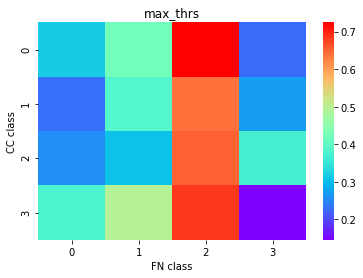

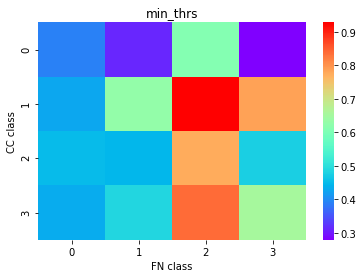

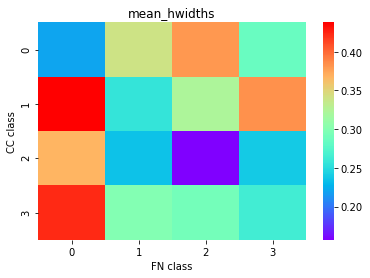

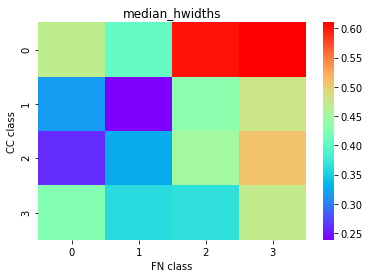

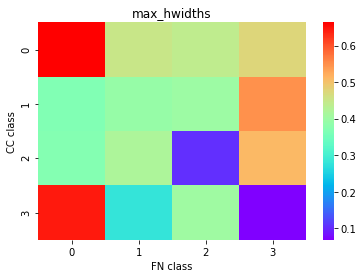

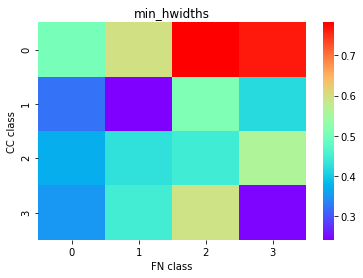

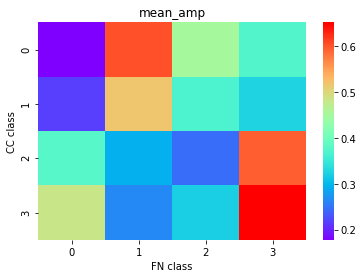

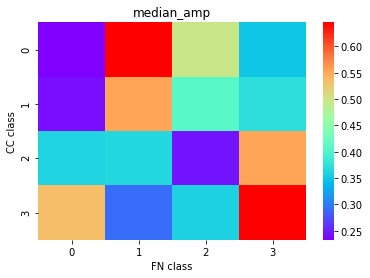

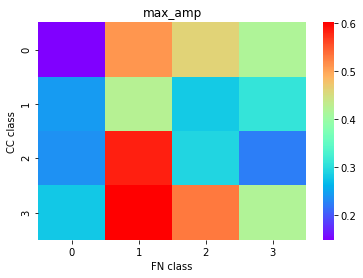

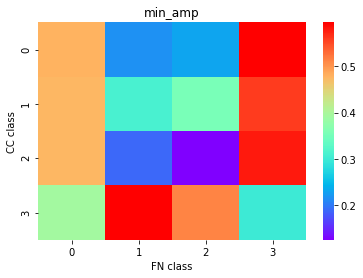

In [86]:
dist_all_inh = np.zeros((len(set(data_FN_inh.lables_lv)),len(set(data_CC_inh.lables_lv))))

for i in range(len(CC_feat)):
    dist_all_inh+= return_wasserstein_distance(data_FN_inh,data_CC_inh,CC_feat[i],FN_feat[i])
    sns.heatmap(return_wasserstein_distance(data_FN_inh,data_CC_inh,CC_feat[i],FN_feat[i]),cmap='rainbow')
    plt.ylabel('CC class')
    plt.xlabel('FN class')
    plt.title(CC_feat[i])    
    plt.show()


In [145]:
df = pd.DataFrame({'expname':data_CC_exc['filename'].to_numpy(),'labels_FN':data_FN_exc['labels_lv'].to_numpy(),'labels_CC':data_CC_exc['labels_lv'].to_numpy()})
# df.sort_values('labels_FN')
print('FN')
for i in set(df.labels_FN): 
    print(len(df[df.labels_FN==i]),np.unique(df[df.labels_FN==i]['labels_CC'],return_counts=True)[1])
print('CC')
for i in set(df.labels_CC): 
    print(len(df[df.labels_CC==i]),np.unique(df[df.labels_CC==i]['labels_FN'],return_counts=True)[1])




KeyError: 'labels_lv'

In [532]:
df = pd.DataFrame({'expname_FN':data_CC_inh['filename'].to_numpy(),'expname_CC':data_FN_inh['exp_name'].to_numpy(),'labels_FN':data_FN_inh['labels_lv'].to_numpy(),'labels_CC':data_CC_inh['labels_lv'].to_numpy()})
# df.sort_values('labels_FN')
# for i in set(df.labels_FN): 
#     print(len(df[df.labels_FN==i]),np.unique(df[df.labels_FN==i]['labels_CC'],return_counts=True)[1])

# for i in set(df.labels_CC): 
#     print(len(df[df.labels_CC==i]),np.unique(df[df.labels_CC==i]['labels_FN'],return_counts=True)[1])
df

,expname_FN,expname_CC,labels_FN,labels_CC
0,170616_NC_20,170616_NC_20,2,1
1,170626_NC_29,170626_NC_29,3,1
2,170627_NC_30,170627_NC_30,0,0
3,170717_NC_65,170717_NC_65,0,3
4,170718_NC_67,170718_NC_67,2,2
5,170718_NC_69,170718_NC_69,0,0
6,170725_NC_82,170725_NC_82,0,3
7,170726_NC_83,170726_NC_83,0,3
8,170726_NC_86,170726_NC_86,1,1
9,170726_NC_87,170726_NC_87,2,0


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


<Axes: >

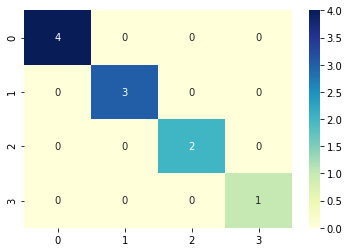

In [348]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(data,feat):
    
    testSize = 0.3;
    RAND_STATE = 20
    UMAP_X = np.stack(data[feat].to_numpy().tolist(), axis=0)
    UMAP_y = data['labels_lv'].to_numpy()

    unclassified_ixs = [ix for ix,clust in enumerate(UMAP_y) if clust == -1]

    UMAP_X = np.delete(UMAP_X,unclassified_ixs,axis=0)
    UMAP_y = np.delete(UMAP_y,unclassified_ixs,axis=0)

    UMAP_X_train, UMAP_X_test, UMAP_y_train, UMAP_y_test = train_test_split(UMAP_X, UMAP_y, test_size=testSize, random_state=RAND_STATE)


    numCV = 5

    UMAP_model = xgb.XGBClassifier()
    UMAP_param_dist = {"max_depth": [4],
                "min_child_weight" : [2.5],
                "n_estimators": [100],
                "learning_rate": [0.3],
                "seed": [RAND_STATE]}
    UMAP_grid_search = GridSearchCV(UMAP_model, param_grid=UMAP_param_dist, 
                            cv = numCV, 
                            verbose=10, n_jobs=-1)
    UMAP_grid_search.fit(UMAP_X_train, UMAP_y_train)

    return  confusion_matrix(UMAP_y_test,UMAP_grid_search.predict(UMAP_X_test))

def get_confusion_matrix_KNN(data,feat,N_clusters):
    

    testSize = 0.3;
    RAND_STATE = 20
    UMAP_X = np.stack(data[feat].to_numpy().tolist(), axis=0)
    UMAP_y = data['labels_lv'].to_numpy()

    unclassified_ixs = [ix for ix,clust in enumerate(UMAP_y) if clust == -1]

    UMAP_X = np.delete(UMAP_X,unclassified_ixs,axis=0)
    UMAP_y = np.delete(UMAP_y,unclassified_ixs,axis=0)

    UMAP_X_train, UMAP_X_test, UMAP_y_train, UMAP_y_test = train_test_split(UMAP_X, UMAP_y, test_size=testSize, random_state=RAND_STATE)


    kmeans = KMeans(n_clusters=N_clusters, random_state=0).fit(UMAP_X_train)
    pred = kmeans.predict(UMAP_X_test)
    
    

    return  confusion_matrix(y,kmeans.labels_)

def plot_confusion_matrix(conf_matrix,labels):
    confusion_mat_counts = conf_matrix
    N_CLUST = len(set(labels))
    conf_mat_row_list = []
    for row in confusion_mat_counts:
        row_sum = np.sum(row)
        
        row_percent = []
        
        for val in row:
            row_percent.append(val/row_sum)
        
        conf_mat_row_list.append(row_percent)

    conf_mat = np.array(conf_mat_row_list)

    colormap = mpl.cm.YlGnBu
    colormap.set_under('white')

    eps = np.spacing(0.0)
    f, arr = plt.subplots(1,figsize=[4,3])
    mappable = arr.imshow(conf_mat,cmap=colormap,vmin=eps,vmax=1.)
    color_bar = f.colorbar(mappable, ax=arr, extend='min')
    color_bar.set_label('P (Predicted | True)',fontsize=12,labelpad=15,fontname="Arial")
    color_bar.ax.tick_params(size=3,labelsize=12)

    #Specify label behavior of the main diagonal
    for i in range(0,N_CLUST):
        if int(conf_mat[i,i]*100) == 100:
            arr.text(i-0.38,i+0.17,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
        else:
            arr.text(i-0.34,i+0.16,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
            
    #Specify label behavior of the off-diagonals
    for i in range(0,N_CLUST):
        for j in range(0,N_CLUST):
            if conf_mat[i,j] < 0.1 and conf_mat[i,j] != 0:
                arr.text(j-0.2,i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")
            elif conf_mat[i,j] >= 0.1 and conf_mat[i,j] < 0.5 and conf_mat[i,j] != 0:
                arr.text(j-0.4, i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")

    arr.set_xticks(range(0,N_CLUST))
    arr.set_xticklabels(range(1,N_CLUST+1),fontsize=12);
    arr.set_yticks(range(0,N_CLUST))
    arr.set_yticklabels(range(1,N_CLUST+1),fontsize=12);
    arr.set_xlabel('Predicted Class',fontsize=12);
    arr.set_ylabel('True Class',fontsize=12);
    plt.tight_layout()

# plot_confusion_matrix(get_confusion_matrix_KNN(data_FN_exc,data_FN_exc.columns[1:-5]),labels_fn_exc)    
# data_FN_exc[data_FN_exc.columns[1:-5]]
sns.heatmap(get_confusion_matrix(data_CC_inh,data_CC_inh.columns[1:-5]),cmap= mpl.cm.YlGnBu,annot=True)
# sns.heatmap(get_confusion_matrix_KNN(data_CC_exc,data_CC_exc.columns[1:-5],len(set(data_CC_exc.labels_lv))),cmap= mpl.cm.YlGnBu,annot=True)


0.0

0.5

1.0

1.5

2.0

2.5

3.0

3.5

4.0

4.5

5.0

0.0

0.5

1.0

1.5

2.0

2.5

3.0

3.5

4.0

4.5

5.0

0.0

0.5

1.0

1.5

2.0

2.5

3.0

3.5

4.0

4.5

5.0

0.0

0.5

1.0

1.5

2.0

2.5

3.0

3.5

4.0

4.5

5.0


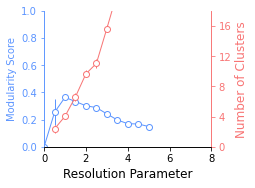

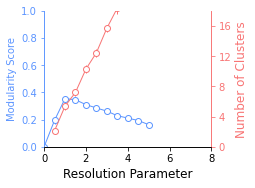

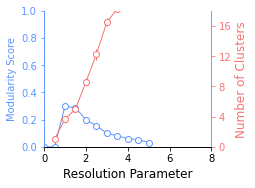

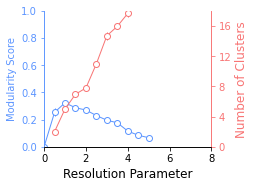

In [533]:
find_optimum_res(data1_exc)
find_optimum_res(data2_exc)
find_optimum_res(data1_inh)
find_optimum_res(data2_inh)

In [22]:
len(data_FN_inh)

32

Index(['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude'],
      dtype='object')
Index(['current_first_spike', 'ap_count', 'abs_firing_rate',
       'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
       'min_isi', 'median_isi', 'mean_thrs', 'max_thrs', 'min_thrs',
       'median_thrs', 'mean_hwidths', 'median_hwidths', 'max_hwidths',
       'min_hwidths', 'first_amp', 'mean_amp', 'median_amp', 'max_amp',
       'min_amp'],
      dtype='object')
use random seed: 42
Shape of Raw data
Dataset 0: (58, 22)
Dataset 1: (58, 22)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu


epoch:[100/500] err:0.3872 alpha:0.9762
epoch:[200/500] err:0.3817 alpha:0.9940
epoch:[300/500] err:0.3740 alpha:1.0162
epoch:[400/500] err:0.3618 alpha:1.0322
epoch:[500/500] err:0.3484 alpha:1.0460
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:0.708938, align_loss:0.106248
epoch:[20/100]: loss:0.873881, align_loss:0.092261
epoch:[30/100]: loss:0.619014, align_loss:0.094603
epoch:[40/100]: loss:0.528786, align_loss:0.084163
epoch:[50/100]: loss:0.649144, align_loss:0.077187
epoch:[60/100]: loss:0.610063, align_loss:0.084794
epoch:[70/100]: loss:0.618886, align_loss:0.075305
epoch:[80/100]: loss:0.642539, align_loss:0.079711
epoch:[90/100]: loss:0.506230, align_loss:0.081987
epoch:[100/100]: loss:0.530622, align_loss:0.078815
Done
---------------------------------
unionCom Done!
time: 3.7816736698150635 seconds
label transfer accuracy of data1:
0.25862068965517243
dataset_num  2


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\unioncom\visualization.py:127: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[i][:,0], e

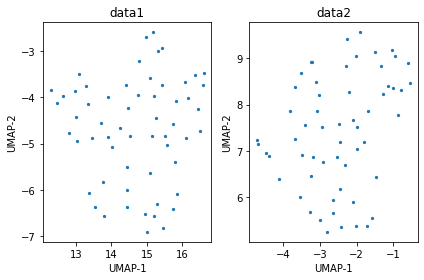

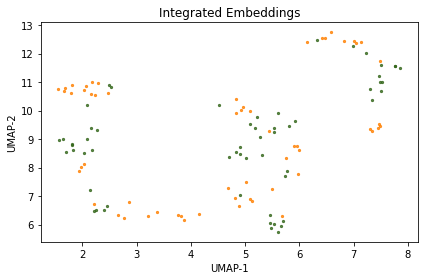

In [182]:

from unioncom import UnionCom
# import numpy as np

data_scaler = StandardScaler()

data1= data_FN_exc[data_FN_exc.columns[:-5]]
data1_exc = data_scaler.fit_transform(data1)


data2 = data_CC_exc[['current_first_spike', 'ap_count', 'abs_firing_rate',
       'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
       'min_isi', 'median_isi', 'mean_thrs', 'max_thrs',
       'min_thrs', 'median_thrs', 'mean_hwidths',
       'median_hwidths', 'max_hwidths', 'min_hwidths', 'first_amp', 'mean_amp',
       'median_amp', 'max_amp', 'min_amp']]
data2_exc = data_scaler.fit_transform(data2)
print(data1.columns)
print(data2.columns)
uc = UnionCom.UnionCom(project_mode='tsne',output_dim=20,manual_seed=42,epoch_pd=500, epoch_DNN=100)
integrated_data = uc.fit_transform(dataset=[data1_exc,data2_exc])
uc.test_LabelTA(integrated_data, [labels_fn_exc,labels_cc_exc])
# uc.Visualize([data1,data2], integrated_data, mode='UMAP') # without datatype
uc.Visualize([data1_exc,data2_exc], integrated_data,mode='UMAP') # without datatype


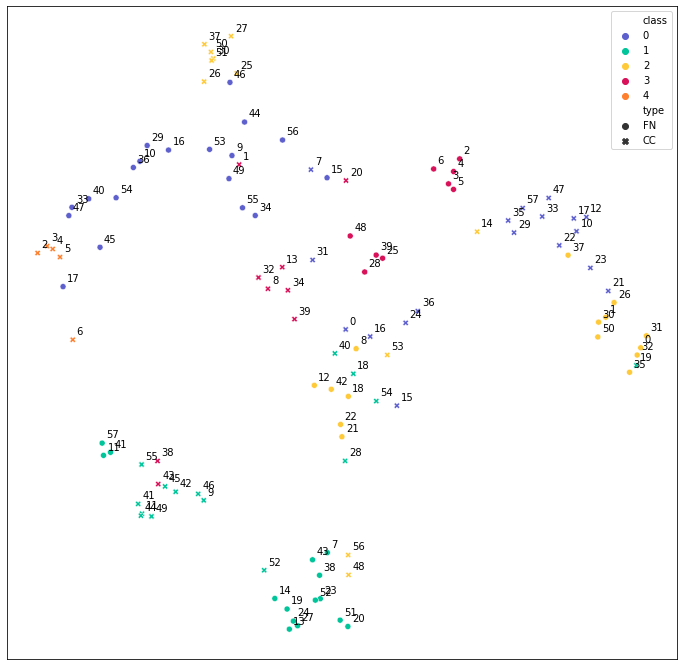

In [183]:

data_umapFN = integrated_data[0]
data_umapCC = integrated_data[1]
data_umap_combined = np.vstack([integrated_data[0],integrated_data[1]])


fig = plt.figure(figsize=[12,12])
ax12d = fig.add_subplot(1,1,1)
random_state =42
neighbours = 20
dist = .1
res_louvain = 1.

reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)

mapperFN = reducer.fit(data_umapFN)
louvain = Louvain(resolution=res_louvain,random_state=random_state)
adjacency = mapperFN.graph_
labels_fn_red = louvain.fit_predict(adjacency)

mapperCC = reducer.fit(data_umapCC)
louvain = Louvain(resolution=res_louvain,random_state=random_state)
adjacency = mapperCC.graph_
labels_cc_red = louvain.fit_predict(adjacency)

clusterable_embedding2d = reducer.fit_transform(data_umap_combined)    


df_2d_exc_fn = {'UMAP1':clusterable_embedding2d[:, 0],
            'UMAP2':clusterable_embedding2d[:, 1],
            'class':np.concatenate([labels_fn_exc,labels_cc_exc]),
            'type':np.concatenate([np.repeat('FN',len(labels_fn_exc)),np.repeat('CC',len(labels_cc_exc))])}


ax12d.set_xticks([])
ax12d.set_yticks([])
markers = {'CC':'*','FN':'o'}
# sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
sns.scatterplot(data=df_2d_exc_fn,x='UMAP1',y='UMAP2',hue='class',style='type',palette=CUSTOM_PAL_SORT_3[:max(len(set(labels_fn_exc)),len(set(labels_cc_exc)))],ax=ax12d)
for i in range(len(clusterable_embedding2d)):
    if i<len(data_umapFN):
        plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))
    else:
        plt.annotate(str(i-len(data_umapFN)),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))


# ax12d.set_title('UMAP clusters for excitatory neurons 2D')
ax12d.legend()


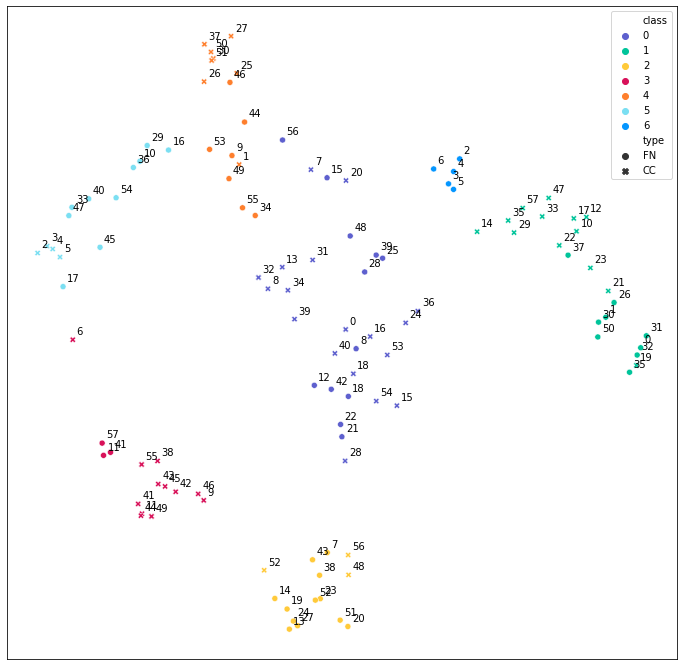

In [184]:

data_umapFN = integrated_data[0]
data_umapCC = integrated_data[1]
data_umap_combined = np.vstack([integrated_data[0],integrated_data[1]])


fig = plt.figure(figsize=[12,12])
ax12d = fig.add_subplot(1,1,1)
random_state =42
neighbours = 20
dist = .1
res_louvain = 1.

reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)

mapperFN = reducer.fit(data_umap_combined)
louvain = Louvain(resolution=res_louvain,random_state=random_state)
adjacency = mapperFN.graph_
labels_fn_red = louvain.fit_predict(adjacency)

clusterable_embedding2d = reducer.fit_transform(data_umap_combined)    


df_2d_exc_fn = {'UMAP1':clusterable_embedding2d[:, 0],
            'UMAP2':clusterable_embedding2d[:, 1],
            'class':labels_fn_red,
            'type':np.concatenate([np.repeat('FN',len(data_umapFN)),np.repeat('CC',len(data_umapCC))])}


ax12d.set_xticks([])
ax12d.set_yticks([])
markers = {'CC':'*','FN':'o'}
# sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
sns.scatterplot(data=df_2d_exc_fn,x='UMAP1',y='UMAP2',style='type',hue='class', palette=CUSTOM_PAL_SORT_3[:len(set(labels_fn_red))],ax=ax12d) #,style='type',palette=CUSTOM_PAL_SORT_3[:len(set(labels_fn_red))],
for i in range(len(clusterable_embedding2d)):
    if i<len(data_umapFN):
        plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))
    else:
        plt.annotate(str(i-len(data_umapFN)),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))


# ax12d.set_title('UMAP clusters for excitatory neurons 2D')
ax12d.legend()


In [1]:
df_exc = pd.DataFrame(columns=['FN_ID','CC_ID','Cluster_ID_FN','Cluster_ID_CC'])
df_exc['FN_ID'] = np.arange(1,len(data_umapFN)+1)
df_exc['CC_ID'] = np.arange(1,len(data_umapCC)+1)
df_exc['Cluster_ID_FN'] = labels_fn_red[:len(data_umapFN)]
df_exc['Cluster_ID_CC'] = labels_fn_red[len(data_umapFN):]
df_exc['diff'] = df_exc['Cluster_ID_FN']-df_exc['Cluster_ID_CC']
np.unique(df_exc['diff'],return_counts=True)
FN_dict = {}
for i in set(df_exc['Cluster_ID_FN']):
    FN_dict[str(i)] = np.unique(df_exc[df_exc['Cluster_ID_FN']==i]['Cluster_ID_CC'],return_counts=True)

NameError: name 'pd' is not defined

{'0': (array([0, 1, 2, 3, 4], dtype=int64),
  array([5, 3, 2, 1, 1], dtype=int64)),
 '1': (array([0, 1, 4], dtype=int64), array([3, 1, 5], dtype=int64)),
 '2': (array([0, 1, 2, 3, 4], dtype=int64),
  array([4, 3, 1, 2, 2], dtype=int64)),
 '3': (array([1, 3], dtype=int64), array([1, 2], dtype=int64)),
 '4': (array([0, 3], dtype=int64), array([2, 5], dtype=int64)),
 '5': (array([0, 1, 3], dtype=int64), array([4, 5, 1], dtype=int64)),
 '6': (array([3, 5], dtype=int64), array([1, 4], dtype=int64))}

use random seed: 42
Shape of Raw data
Dataset 0: (32, 22)
Dataset 1: (32, 22)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/500] err:0.3596 alpha:0.6021
epoch:[200/500] err:0.3616 alpha:0.6223
epoch:[300/500] err:0.3570 alpha:0.6360
epoch:[400/500] err:0.3486 alpha:0.6449
epoch:[500/500] err:0.3393 alpha:0.6520
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:0.176961, align_loss:0.028371
epoch:[20/100]: loss:0.155553, align_loss:0.012914
epoch:[30/100]: loss:0.125729, align_loss:0.007936
epoch:[40/100]: loss:0.092471, align_loss:0.006544
epoch:[50/100]: loss:0.087239, align_loss:0.005597
epoch:[60/100]: loss:0.090239, align_loss:0.004978
epoch:[70/100]: loss:0.110595, align_loss:0.005020
epoch:[80/100]: loss:0.130034, align_loss:0.004760
epoch:[90/100]: loss:0.097548, align_loss:0.003939
epoch:[100/100]: loss:0.090168, align_loss:0.004066
Done
------------------

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\unioncom\visualization.py:127: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[i][:,0], embedding[i][:,1], c=color[i], s=5., alpha=0.8)


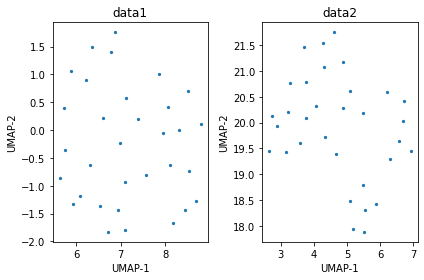

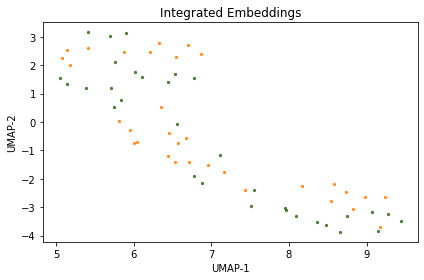

In [152]:

from unioncom import UnionCom
# import numpy as np


data_scaler = StandardScaler()

data1= data_FN_inh[data_FN_inh.columns[:-5]]
data1_inh = data_scaler.fit_transform(data1)

data2 = data_CC_inh[['current_first_spike', 'ap_count', 'abs_firing_rate',
       'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
       'min_isi', 'median_isi', 'mean_thrs', 'max_thrs',
       'min_thrs', 'median_thrs', 'mean_hwidths',
       'median_hwidths', 'max_hwidths', 'min_hwidths', 'first_amp', 'mean_amp',
       'median_amp', 'max_amp', 'min_amp']]
data2_inh = data_scaler.fit_transform(data2)

uc = UnionCom.UnionCom(project_mode='tsne',output_dim=20,manual_seed=42,epoch_pd=500,epoch_DNN=100)
integrated_data = uc.fit_transform(dataset=[data1_inh,data2_inh])

# uc.Visualize([data1_inh,data2_inh], integrated_data, mode='UMAP') # without datatype
# uc.test_labelTA(integrated_data, [type1,type2])
uc.Visualize([data1_inh,data2_inh], integrated_data,mode='UMAP') # without datatype

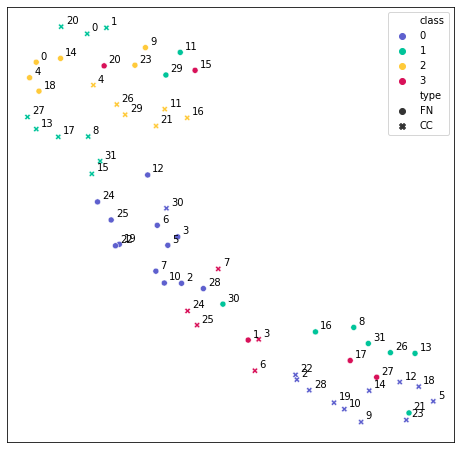

In [153]:

data_umapFN = integrated_data[0]
data_umapCC = integrated_data[1]


fig = plt.figure(figsize=[8,8])
ax12d = fig.add_subplot(1,1,1)
random_state =42
neighbours = 15
dist = .1
res_louvain = 1.

reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)

mapperFN = reducer.fit(data_umapFN)
louvain = Louvain(resolution=res_louvain,random_state=random_state)
adjacency = mapperFN.graph_
labels_fn_red = louvain.fit_predict(adjacency)

mapperCC = reducer.fit(data_umapCC)
louvain = Louvain(resolution=res_louvain,random_state=random_state)
adjacency = mapperCC.graph_
labels_cc_red = louvain.fit_predict(adjacency)

data_umap_combined = np.vstack([data_umapFN,data_umapCC])
clusterable_embedding2d_FN = reducer.fit_transform(data_umap_combined)    
# clusterable_embedding2d_CC = reducer.fit_transform(data_umapCC)    
data_umap_combined.shape

df_2d_exc_fn = {'UMAP1':clusterable_embedding2d_FN[:, 0],
            'UMAP2':clusterable_embedding2d_FN[:, 1],
            'class':np.concatenate((labels_fn_inh,labels_cc_inh)),
            'type':np.concatenate([np.repeat('FN',len(labels_fn_inh)),np.repeat('CC',len(labels_cc_inh))])}


ax12d.set_xticks([])
ax12d.set_yticks([])
markers = {'CC':'*','FN':'o'}

sns.scatterplot(data=df_2d_exc_fn,x='UMAP1',y='UMAP2',hue='class',style='type',palette=CUSTOM_PAL_SORT_3[:max(len(set(labels_cc_inh)),len(set(labels_fn_inh)))],ax=ax12d)

for i in range(len(clusterable_embedding2d_FN)):
    if i<len(data_umapFN):
        plt.annotate(str(i),(clusterable_embedding2d_FN[i,0]+0.05,clusterable_embedding2d_FN[i,1]+0.05))
    else:
        plt.annotate(str(i-len(data_umapFN)),(clusterable_embedding2d_FN[i,0]+0.05,clusterable_embedding2d_FN[i,1]+0.05))

ax12d.legend()


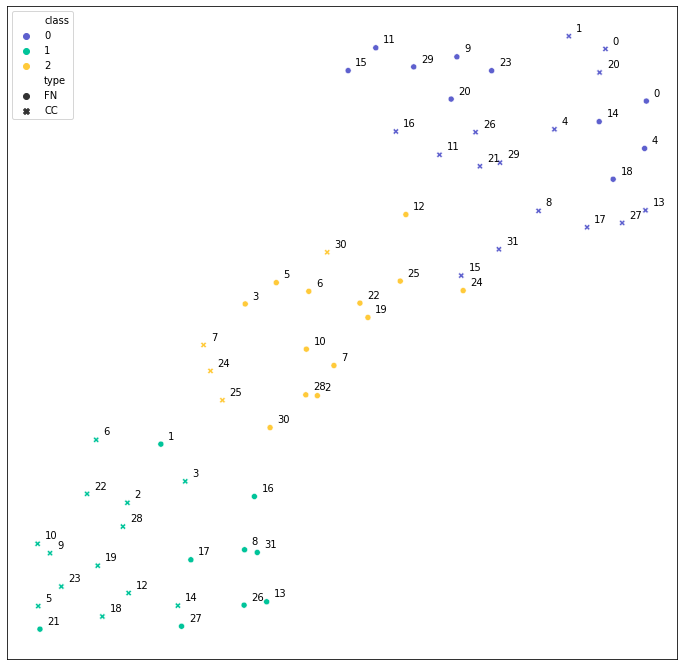

In [154]:

data_umapFN = integrated_data[0]
data_umapCC = integrated_data[1]
data_umap_combined = np.vstack([integrated_data[0],integrated_data[1]])


fig = plt.figure(figsize=[12,12])
ax12d = fig.add_subplot(1,1,1)
random_state =42
neighbours = 20
dist = .1
res_louvain = 1.

reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)

mapperFN = reducer.fit(data_umap_combined)
louvain = Louvain(resolution=res_louvain,random_state=random_state)
adjacency = mapperFN.graph_
labels_fn_red = louvain.fit_predict(adjacency)

clusterable_embedding2d = reducer.fit_transform(data_umap_combined)    


df_2d_exc_fn = {'UMAP1':clusterable_embedding2d[:, 0],
            'UMAP2':clusterable_embedding2d[:, 1],
            'class':labels_fn_red,
            'type':np.concatenate([np.repeat('FN',len(data_umapFN)),np.repeat('CC',len(data_umapCC))])}


ax12d.set_xticks([])
ax12d.set_yticks([])
markers = {'CC':'*','FN':'o'}
# sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
sns.scatterplot(data=df_2d_exc_fn,x='UMAP1',y='UMAP2',style='type',hue='class', palette=CUSTOM_PAL_SORT_3[:len(set(labels_fn_red))],ax=ax12d) #,style='type',palette=CUSTOM_PAL_SORT_3[:len(set(labels_fn_red))],
for i in range(len(clusterable_embedding2d)):
    if i<len(data_umapFN):
        plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))
    else:
        plt.annotate(str(i-len(data_umapFN)),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))


# ax12d.set_title('UMAP clusters for excitatory neurons 2D')
ax12d.legend()


In [194]:
df = pd.DataFrame(columns=['FN_ID','CC_ID','Cluster_ID_FN','Cluster_ID_CC'])
df['FN_ID'] = np.arange(1,len(data_umapFN)+1)
df['CC_ID'] = np.arange(1,len(data_umapCC)+1)
df['Cluster_ID_FN'] = labels_fn_red[:len(data_umapFN)]
df['Cluster_ID_CC'] = labels_fn_red[len(data_umapFN):]
df['diff'] = df['Cluster_ID_FN']-df['Cluster_ID_CC']
np.unique(df['diff'],return_counts=True)

(array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5], dtype=int64),
 array([ 1,  6,  4,  5,  9, 15,  6,  1,  7,  4], dtype=int64))

In [195]:
df[df['Cluster_ID_FN']==0]

,FN_ID,CC_ID,Cluster_ID_FN,Cluster_ID_CC,diff
8,9,9,0,0,0
12,13,13,0,1,-1
15,16,16,0,0,0
18,19,19,0,0,0
21,22,22,0,1,-1
22,23,23,0,1,-1
25,26,26,0,4,-4
28,29,29,0,0,0
39,40,40,0,0,0
42,43,43,0,3,-3


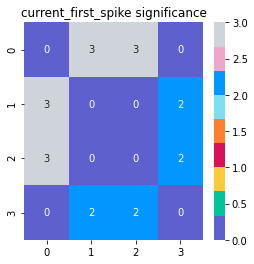

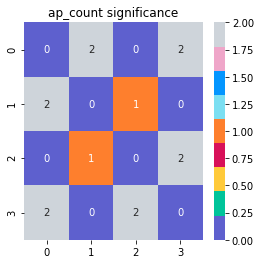

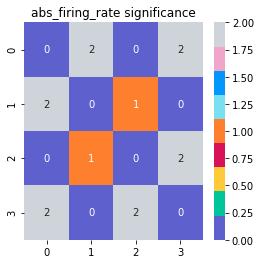

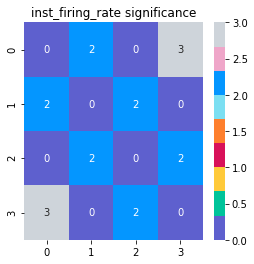

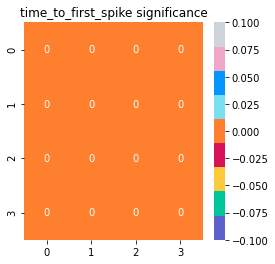

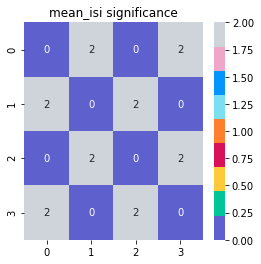

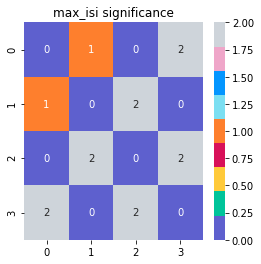

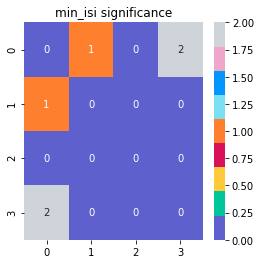

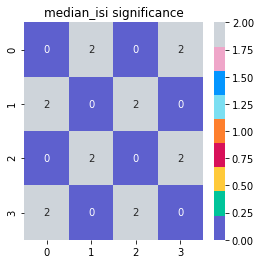

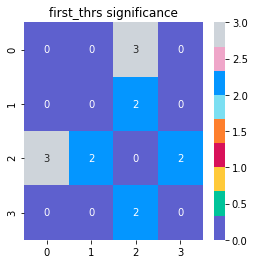

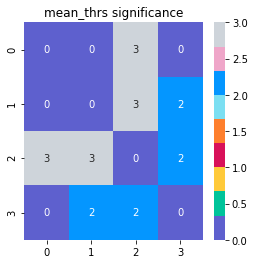

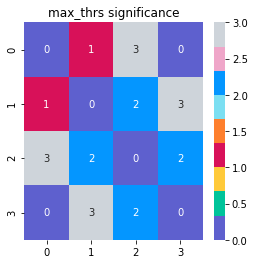

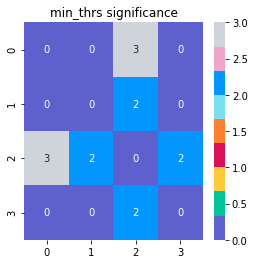

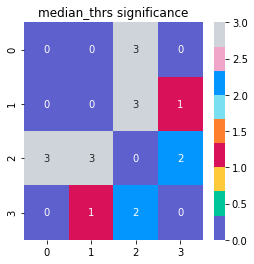

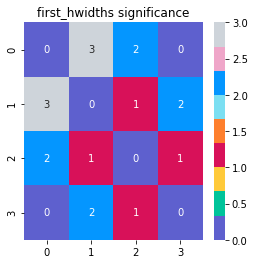

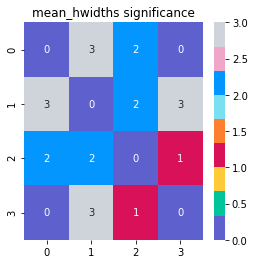

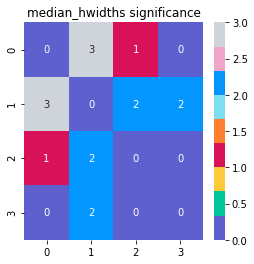

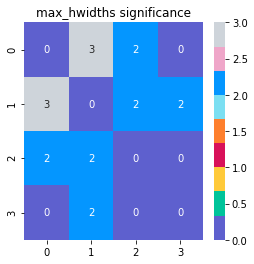

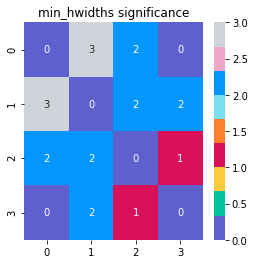

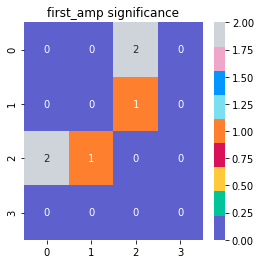

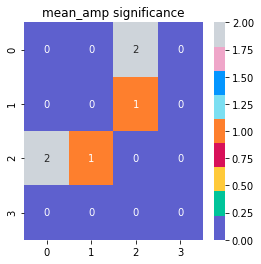

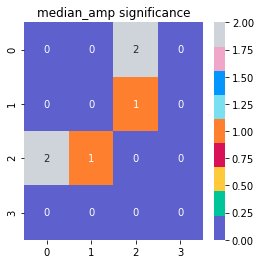

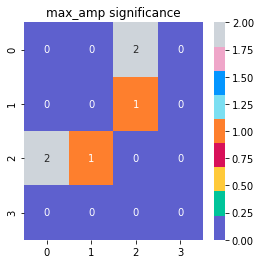

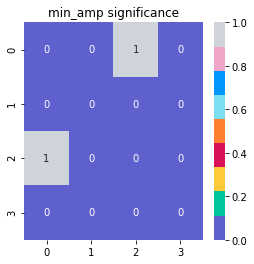

In [553]:
from scipy.stats import mannwhitneyu
from itertools import combinations
from statannotations.Annotator import Annotator
def get_pvalues(data,var,hue):
    df = data
    x = hue
    y = var

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(pairs,2)]
    test_short_name = 'Mann-Whitney'
    pvalues = []
    sigs = []
    for pair in pairs:
        data1 = df.groupby(x)[y].get_group(pair[0])
        data2 = df.groupby(x)[y].get_group(pair[1])
        stat, p = mannwhitneyu(data1, data2)
        pvalues.append(p)

        if  p > 5.00e-02 and p <= 1.00e+00:
            sigs.append(0)
        elif 1.00e-02 < p and p <= 5.00e-02:
            sigs.append(1)
        elif 1.00e-03 < p and p<= 1.00e-02:
            sigs.append(2)
        elif 1.00e-04 < p and p<= 1.00e-03:
            sigs.append(3)   
        elif  p <= 1.00e-04:
            sigs.append(4)   

    sig_matrix = np.zeros((len(set(data.labels_lv)),len(set(data.labels_lv))))
    for i,j in enumerate(pairs):
        sig_matrix[j] = sigs[i]
    sig_matrix = sig_matrix+sig_matrix.T     
    return sig_matrix# pvalues,pairs,sigs


sig_all_inh = []
for val in data_CC_inh.columns[:-4]:    
    sig_matrix = get_pvalues(data_CC_inh,var = val,hue = 'labels_lv',)
    sig_all_inh.append(sig_matrix)
    fig,ax = plt.subplots(1,1,figsize=[4,4])
    sns.heatmap(sig_matrix,annot=True,ax=ax,cmap=CUSTOM_PAL_SORT_3)
    ax.set_title(val+' significance')
    plt.show()

<Axes: >

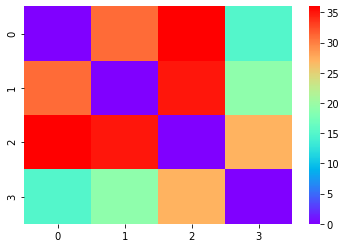

In [554]:
a_inh = np.zeros_like(sig_all_inh[0])
for i in np.arange(len(sig_all_inh)):
    a_inh += sig_all_inh[i]
sns.heatmap(a_inh,cmap='rainbow')


Plot UMAP for all CC files shared on Monday (07/09/23)

5


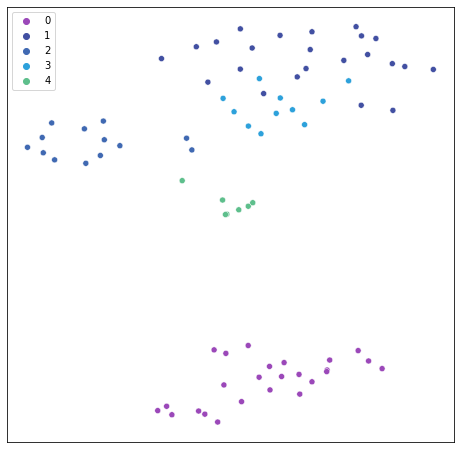

5


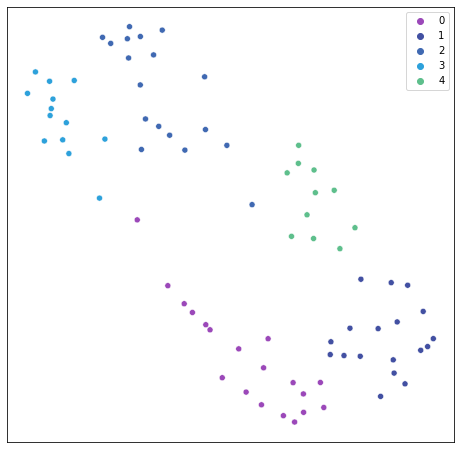

In [42]:
data = pd.read_csv('D:/Cluster Feature files/CC_NC_DB.csv')
files_ID = pd.read_csv('D:/lists/NC_DB_for_cluster.csv')

NC_CC_DB = data[data.name=='NC']
NC_CC_DB = NC_CC_DB[NC_CC_DB.exp_number.isin(set(files_ID.exp_number))] 
NC_CC_DB_1 =  NC_CC_DB[NC_CC_DB.trialnr==1]

NC_FN_DB = NC_data[NC_data.exp_name.isin(set(files_ID.Fn_files))]

NC_FN_DB_1 = NC_FN_DB[NC_FN_DB.trialnr==1]
NC_FN_DB_1 = NC_FN_DB_1.drop_duplicates('exp_name')

feats_CC = NC_CC_DB.columns

feats_FN = NC_FN_DB.columns

labels_cc,mapper,reducer = plot_UMAP_clusters_single(NC_CC_DB_1[feats_CC[:-6]],
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list = coherence_colors
                          )

labels_fn,mapper,reducer = plot_UMAP_clusters_single(NC_FN_DB_1[feats_FN[:-7]],
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list = coherence_colors
                          )


In [61]:
NC_CC_DB_1['CC_labels'] = labels_cc
NC_FN_DB_1['FN_labels'] = labels_fn
NC_FN_DB_1

<ipython-input-61-e2e5933a8e35>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NC_CC_DB_1['CC_labels'] = labels_cc


,current_at_first_spike,ap_count,fr,inst_fr,time_to_first_spike,mean_isi,median_isi,max_isi,min_isi,first_thr,...,min_amplitude,max_amplitude,exp_name,cond,trialnr,ei_labels,date,name,exp_number,FN_labels
0,8.200875,291,0.887500,0.046849,2703.35,1224.064483,274.250,15331.60,6.45,-44.218749,...,51.062500,132.343750,NC_170711_aCSF_D1ago_E1,acsf,1,0,170711,NC,E1,2
4,196.910798,127,0.383333,0.005651,8316.55,2772.755159,1818.250,15337.05,15.15,-36.125001,...,56.250000,103.874996,NC_170712_aCSF_D1ago_E1,acsf,1,0,170712,NC,E1,1
5,136.330819,171,1.870000,0.032204,2101.80,2103.784412,1570.900,16483.80,4.10,-27.500000,...,4.750000,115.999997,NC_170712_aCSF_D1ago_E2,acsf,1,0,170712,NC,E2,2
8,159.948951,208,0.623333,0.005363,2114.20,1717.713285,1007.400,15333.75,11.20,-38.249999,...,24.406250,90.500001,NC_170713_aCSF_DopD2D1_E3,acsf,1,0,170713,NC,E3,0
9,17.677462,1381,4.370000,0.025703,183.20,260.546667,139.400,2634.55,6.60,-39.781250,...,8.281250,100.812502,NC_170713_aCSF_DopD2D1_E4,acsf,1,0,170713,NC,E4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,0.452788,1556,4.361111,0.027709,174.85,231.392026,102.800,2349.75,5.60,-33.281252,...,60.156249,95.624998,NC_170815_aCSF_D1ago_E1,acsf,1,1,170815,NC,E1,5
654,176.392417,2258,6.272222,0.028734,173.75,159.422153,70.850,1645.15,6.10,-42.218748,...,41.999999,105.624998,NC_170815_aCSF_D1ago_E3,acsf,1,1,170815,NC,E3,4
664,151.247567,1260,3.500000,0.021509,174.35,285.790667,148.250,2502.45,5.15,-41.749999,...,67.343751,100.000001,NC_170914_aCSF_D1ago_E1,acsf,1,1,170914,NC,E1,3
692,156.268867,1942,5.877778,0.024512,173.60,185.372257,98.150,1644.75,5.95,-29.531250,...,37.968749,86.906251,NC_171211_aCSF_E1,acsf,1,1,171211,NC,E1,5


In [62]:
merged=pd.merge(files_ID, NC_CC_DB_1[['exp_number','CC_labels']], left_on='exp_number', right_on='exp_number', how='left',sort=True)
merged = pd.merge(merged, NC_FN_DB_1[['exp_name','FN_labels']], left_on='Fn_files', right_on='exp_name', how='left',sort=True)
CC_FN_corresp = {}
for i in set(NC_CC_DB_1.CC_labels):
    temp = merged[merged.FN_labels==i]
    CC_FN_corresp['FN_'+str(i)] = np.unique(temp['CC_labels'],return_counts=True)
CC_FN_corresp

{'FN_0': (array([1., 2., 3., 5.]), array([6, 6, 2, 4], dtype=int64)),
 'FN_1': (array([0., 1., 2., 3., 4., 5.]),
  array([1, 2, 7, 5, 1, 1], dtype=int64)),
 'FN_2': (array([0., 1., 2., 3.]), array([1, 5, 3, 5], dtype=int64)),
 'FN_3': (array([0., 4.]), array([10,  1], dtype=int64)),
 'FN_4': (array([ 0.,  1.,  5., nan]), array([4, 2, 1, 3], dtype=int64)),
 'FN_5': (array([0., 1., 4.]), array([2, 1, 6], dtype=int64))}

In [11]:
cells,features = waves_inh_FN.shape
pca = PCA(n_components=features)
scaler = StandardScaler()
data_all = waves_inh_FN
data_all = scaler.fit_transform(data_all)
data_all = normalize(data_all)
pca.fit(data_all)
eigenvalues = pca.explained_variance_
sum(eigenvalues)**2/sum(eigenvalues**2)

NameError: name 'waves_inh_FN' is not defined

Manifold alignment between all FN and CC cells (new data)

use random seed: 42
Shape of Raw data
Dataset 0: (79, 22)
Dataset 1: (79, 24)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/500] err:0.7979 alpha:0.8147
epoch:[200/500] err:0.8144 alpha:0.8390
epoch:[300/500] err:0.8188 alpha:0.8526
epoch:[400/500] err:0.8181 alpha:0.8602
epoch:[500/500] err:0.8148 alpha:0.8659
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:1.151733, align_loss:0.097437
epoch:[20/100]: loss:0.847603, align_loss:0.098548
epoch:[30/100]: loss:0.753850, align_loss:0.091344
epoch:[40/100]: loss:0.813310, align_loss:0.093428
epoch:[50/100]: loss:0.698903, align_loss:0.094767
epoch:[60/100]: loss:0.742357, align_loss:0.095624
epoch:[70/100]: loss:0.619969, align_loss:0.101774
epoch:[80/100]: loss:0.717734, align_loss:0.100696
epoch:[90/100]: loss:0.707013, align_loss:0.092322
epoch:[100/100]: loss:0.712666, align_loss:0.094416
Done
------------------

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\unioncom\visualization.py:127: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[i][:,0], embedding[i][:,1], c=color[i], s=5., alpha=0.8)


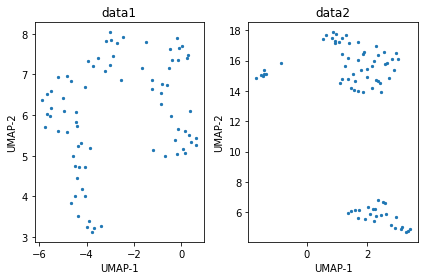

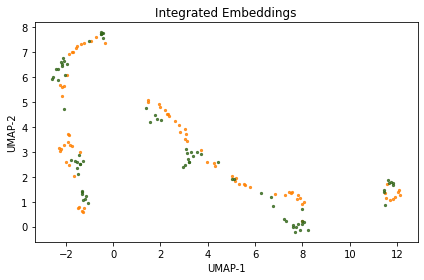

In [56]:

from unioncom import UnionCom
# import numpy as np
data = pd.read_csv('D:/Cluster Feature files/CC_NC_DB.csv')
files_ID = pd.read_csv('D:/lists/NC_DB_for_cluster.csv')

NC_CC_DB = data[data.name=='NC']
NC_CC_DB = NC_CC_DB[NC_CC_DB.exp_number.isin(set(files_ID.exp_number))] 
NC_CC_DB_1 =  NC_CC_DB[NC_CC_DB.trialnr==1]

NC_FN_DB = NC_data[NC_data.exp_name.isin(set(files_ID.Fn_files))]

NC_FN_DB_1 = NC_FN_DB[NC_FN_DB.trialnr==1]
NC_FN_DB_1 = NC_FN_DB_1.drop_duplicates('exp_name')

# feats_CC = ['current_first_spike', 'ap_count', 'abs_firing_rate',
#        'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
#        'min_isi', 'median_isi', 'first_thrs', 'mean_thrs', 'max_thrs',
#        'min_thrs', 'median_thrs', 'mean_hwidths',
#        'median_hwidths', 'max_hwidths', 'min_hwidths', 'mean_amp',
#        'median_amp', 'max_amp', 'min_amp']

feats_CC = NC_CC_DB.columns
feats_FN = NC_FN_DB.columns

data_scaler = StandardScaler()
NC_FN_1 = NC_FN_DB_1
NC_CC_1 = NC_CC_DB_1

data1= NC_FN_1[NC_FN_1.columns[:-7]]
data1 = data_scaler.fit_transform(data1)
data1 = normalize(data1)
data2 = NC_CC_1[feats_CC[:-5]]
data2 = data_scaler.fit_transform(data2)
data2 = normalize(data2)
uc = UnionCom.UnionCom(project_mode='tsne',output_dim=10,manual_seed=42,epoch_pd=500,epoch_DNN=100)
integrated_data = uc.fit_transform(dataset=[data1,data2])

# uc.Visualize([data1,data2], integrated_data, mode='UMAP') # without datatype
uc.Visualize([data1,data2], integrated_data,mode='UMAP') # without datatype


{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}


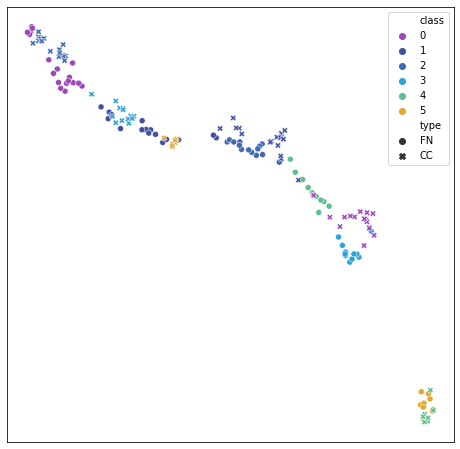

In [63]:

data_umapFN = integrated_data[0]
data_umapCC = integrated_data[1]
data_umap_combined = np.vstack([integrated_data[0],integrated_data[1]])


fig = plt.figure(figsize=[8,8])
ax12d = fig.add_subplot(1,1,1)
random_state =42
neighbours = 20
dist = .1
res_louvain = 1.

reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)

mapperFN = reducer.fit(data_umapFN)
louvain = Louvain(resolution=res_louvain,random_state=random_state)
adjacency = mapperFN.graph_
labels_fn_red = louvain.fit_predict(adjacency)
print(set(labels_fn))
mapperCC = reducer.fit(data_umapCC)
louvain = Louvain(resolution=res_louvain,random_state=random_state)
adjacency = mapperCC.graph_
labels_cc_red = louvain.fit_predict(adjacency)
print(set(labels_cc))

clusterable_embedding2d = reducer.fit_transform(data_umap_combined)    


df_2d_exc_fn = {'UMAP1':clusterable_embedding2d[:, 0],
            'UMAP2':clusterable_embedding2d[:, 1],
            'class':np.concatenate([labels_fn,labels_cc]),
            'type':np.concatenate([np.repeat('FN',len(labels_fn)),np.repeat('CC',len(labels_cc))])}


ax12d.set_xticks([])
ax12d.set_yticks([])
markers = {'CC':'*','FN':'o'}
# sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
sns.scatterplot(data=df_2d_exc_fn,x='UMAP1',y='UMAP2',hue='class',style='type',palette=coherence_colors[:len(set(labels_cc))],ax=ax12d)


# ax12d.set_title('UMAP clusters for excitatory neurons 2D')
ax12d.legend()


In [67]:
NC_CC_DB_1['CC_labels_after_red'] = labels_cc_red
NC_FN_DB_1['FN_labels_after_red'] = labels_fn_red
merged=pd.merge(files_ID, NC_CC_DB_1[['exp_number','CC_labels_after_red']], left_on='exp_number', right_on='exp_number', how='left',sort=True)
merged = pd.merge(merged, NC_FN_DB_1[['exp_name','FN_labels_after_red']], left_on='Fn_files', right_on='exp_name', how='left',sort=True)
CC_FN_corresp = {}
for i in set(NC_CC_DB_1.CC_labels_after_red):
    temp = merged[merged.FN_labels_after_red==i]
    CC_FN_corresp['FN_'+str(i)] = np.unique(temp['CC_labels_after_red'],return_counts=True)
CC_FN_corresp

<ipython-input-67-56fff98acb29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NC_CC_DB_1['CC_labels_after_red'] = labels_cc_red


{'FN_0': (array([1., 2., 3., 5.]), array([6, 6, 2, 4], dtype=int64)),
 'FN_1': (array([0., 1., 2., 3., 4., 5.]),
  array([1, 2, 7, 5, 1, 1], dtype=int64)),
 'FN_2': (array([0., 1., 2., 3.]), array([1, 5, 3, 5], dtype=int64)),
 'FN_3': (array([0., 4.]), array([10,  1], dtype=int64)),
 'FN_4': (array([ 0.,  1.,  5., nan]), array([4, 2, 1, 3], dtype=int64)),
 'FN_5': (array([0., 1., 4.]), array([2, 1, 6], dtype=int64))}

dataset_num  2


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\unioncom\visualization.py:96: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[i][:,0], embedding[i][:,1], c=color[i], s=5., alpha=0.8)


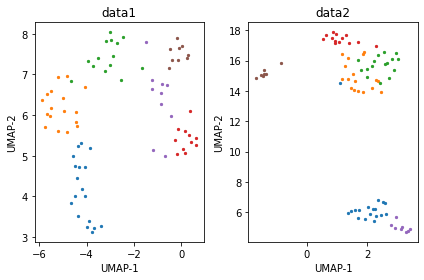

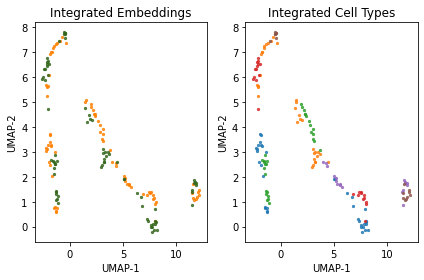

In [64]:
uc.Visualize([data1,data2], integrated_data, datatype=[labels_fn_red,labels_cc_red],mode='UMAP') # without datatype


In [68]:
uc.test_LabelTA(integrated_data,[labels_fn_red,labels_cc_red])

label transfer accuracy of data1:
0.0


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [ ]:
#Importing libraries
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram , linkage
 
#Getting the data ready


#Linkage Matrix
def plot_dendro(data):
    Z = linkage(data, method = 'ward')
 
    #plotting dendrogram
    dendro = dendrogram(Z)
    plt.title('Dendrogram')
    plt.ylabel('Euclidean distance')
    plt.show()
plot_dendro(waves_inh_FN)   
plot_dendro(waves_exc_FN)   

plot_dendro(waves_inh_CC)   
plot_dendro(waves_exc_CC)   


In [ ]:
resolution_list = np.linspace(0,5,11)
modularity_dict = {}
n_clusts_dict = {}
#Louvain Clustering Parameters
RESOLUTION = 1.5
random_state = 42
full_data = df_waves_acsf['waveforms']
# BLUE COLOR
BlueCol = '\033[94m'
subsets=[100]
import random 
for res in resolution_list:
    print("\n" + BlueCol + str(res))
    for frac in subsets:
        rand_list = []
        n_clusts = []
        for i in list(range(1,25)):
            reducer_rand_test = umap.UMAP(n_neighbors = 20, 
                                     min_dist=0.0, 
                                     random_state=random.randint(1,100000))
            rand_data = np.vstack(np.random.permutation(full_data))
            mapper = reducer_rand_test.fit(rand_data)
            embedding_rand_test = reducer_rand_test.transform(rand_data)

            umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
            louvain = Louvain(resolution=res,random_state=random_state)
            adjacency = mapper.graph_
            labels_exc = louvain.fit_predict(adjacency)
            clustering_solution = labels_exc
            modularity= get_modularity(adjacency,labels_exc)
            rand_list.append(modularity)
            n_clusts.append(len(set(clustering_solution)))
        modularity_dict.update({str(res): rand_list})
        n_clusts_dict.update({str(res): n_clusts})


resolution_list = np.linspace(0,5,11)

if 'n_clusts_dict' not in list(locals().keys()):
  n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

if 'modularity_dict' not in list(locals().keys()):
  modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

avg_n_clusts = []
for k in list(n_clusts_dict.keys()):
    avg_n_clusts.append(np.mean(n_clusts_dict[k]))
    
std_n_clusts = []
for k in list(n_clusts_dict.keys()):
    std_n_clusts.append(np.std(n_clusts_dict[k]))
    
std_modularity = []
for k in list(modularity_dict.keys()):
    std_modularity.append(np.std(modularity_dict[k]))
    
avg_modularity = []
for k in list(modularity_dict.keys()):
    avg_modularity.append(np.mean(modularity_dict[k]))

f, ax1 = plt.subplots(figsize=[3,2.5])

ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
             c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
             linewidth=1, markeredgewidth=1)
ax1.set_ylabel('Modularity Score')
ax1.set_xlabel('Resolution Parameter',fontsize=12)
ax1.set_xlim([0,8])
ax1.set_xticks([0,2,4,6,8])
ax1.yaxis.label.set_color('#5c95ff')
ax1.tick_params(axis='y',colors='#5c95ff')
ax1.set_ylim(0,1.0)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_color('#f87575')
ax1.spines['left'].set_color('#5c95ff')

ax2 = ax1.twinx()
ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
            c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
# ax2.spines['left'].set_color('b')
ax2.tick_params(axis='y',colors='#f87575')
ax2.set_ylim([0,18])
ax2.set_yticks([0,4,8,12,16]);
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('#f87575')
ax2.spines['left'].set_color('#5c95ff')

In [ ]:
# data_umap = exc_inh_df[features_ext_sub][exc_inh_df.ei_labels == 0]
data_umap = waves_all
cells,features = data_umap.shape
pca = PCA(n_components=features)
scaler = StandardScaler()
data_all = data_umap
data_all = scaler.fit_transform(data_all)
data_all = normalize(data_all)
pca.fit(data_all)
eigenvalues = pca.explained_variance_
sum(eigenvalues)**2/sum(eigenvalues**2)

In [ ]:
sns.histplot(exc_df_acsf['labels_lv']+1,discrete=True)
sns.histplot(exc_df_acsf['labels_lv']+1,discrete=True)


In [ ]:
plt.scatter(np.arange(len(eigenvalues)),eigenvalues)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(data,feat):
    
    testSize = 0.3;
    RAND_STATE = 20
    UMAP_X = np.stack(data[feat].to_numpy().tolist(), axis=0)
    UMAP_y = data['labels_lv'].to_numpy()

    unclassified_ixs = [ix for ix,clust in enumerate(UMAP_y) if clust == -1]

    UMAP_X = np.delete(UMAP_X,unclassified_ixs,axis=0)
    UMAP_y = np.delete(UMAP_y,unclassified_ixs,axis=0)

    UMAP_X_train, UMAP_X_test, UMAP_y_train, UMAP_y_test = train_test_split(UMAP_X, UMAP_y, test_size=testSize, random_state=RAND_STATE)


    numCV = 5

    UMAP_model = xgb.XGBClassifier()
    UMAP_param_dist = {"max_depth": [4],
                "min_child_weight" : [2.5],
                "n_estimators": [100],
                "learning_rate": [0.3],
                "seed": [RAND_STATE]}
    UMAP_grid_search = GridSearchCV(UMAP_model, param_grid=UMAP_param_dist, 
                            cv = numCV, 
                            verbose=10, n_jobs=-1)
    UMAP_grid_search.fit(UMAP_X_train, UMAP_y_train)

    return  confusion_matrix(UMAP_y_test,UMAP_grid_search.predict(UMAP_X_test))


In [ ]:
def plot_confusion_matrix(conf_matrix,labels):
    confusion_mat_counts = conf_matrix
    N_CLUST = len(set(labels))
    conf_mat_row_list = []
    for row in confusion_mat_counts:
        row_sum = np.sum(row)
        
        row_percent = []
        
        for val in row:
            row_percent.append(val/row_sum)
        
        conf_mat_row_list.append(row_percent)

    conf_mat = np.array(conf_mat_row_list)

    colormap = mpl.cm.YlGnBu
    colormap.set_under('white')

    eps = np.spacing(0.0)
    f, arr = plt.subplots(1,figsize=[4,3])
    mappable = arr.imshow(conf_mat,cmap=colormap,vmin=eps,vmax=1.)
    color_bar = f.colorbar(mappable, ax=arr, extend='min')
    color_bar.set_label('P (Predicted | True)',fontsize=12,labelpad=15,fontname="Arial")
    color_bar.ax.tick_params(size=3,labelsize=12)

    #Specify label behavior of the main diagonal
    for i in range(0,N_CLUST):
        if int(conf_mat[i,i]*100) == 100:
            arr.text(i-0.38,i+0.17,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
        else:
            arr.text(i-0.34,i+0.16,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
            
    #Specify label behavior of the off-diagonals
    for i in range(0,N_CLUST):
        for j in range(0,N_CLUST):
            if conf_mat[i,j] < 0.1 and conf_mat[i,j] != 0:
                arr.text(j-0.2,i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")
            elif conf_mat[i,j] >= 0.1 and conf_mat[i,j] < 0.5 and conf_mat[i,j] != 0:
                arr.text(j-0.4, i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")

    arr.set_xticks(range(0,N_CLUST))
    arr.set_xticklabels(range(1,N_CLUST+1),fontsize=12);
    arr.set_yticks(range(0,N_CLUST))
    arr.set_yticklabels(range(1,N_CLUST+1),fontsize=12);
    arr.set_xlabel('Predicted Class',fontsize=12);
    arr.set_ylabel('True Class',fontsize=12);
    plt.tight_layout()

plot_confusion_matrix(get_confusion_matrix(inh_df_acsf,feat[:-1]),labels_inh)    

In [ ]:
exc_df_acsf['labels_lv'] = labels_exc

plot_confusion_matrix(get_confusion_matrix(exc_df_acsf,feat[:-1]),labels_exc)    

In [ ]:
resolution_list = np.linspace(0,5,11)
modularity_dict = {}
n_clusts_dict = {}
#Louvain Clustering Parameters
RESOLUTION = 1.5
random_state = 42
full_data = join_wave_with_ephys(feat, exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf['ephys_labels']==0])
# BLUE COLOR
BlueCol = '\033[94m'
subsets=[100]
import random 
for res in resolution_list:
    print("\n" + BlueCol + str(res))
    for frac in subsets:
        rand_list = []
        n_clusts = []
        for i in list(range(1,25)):
            reducer_rand_test = umap.UMAP(n_neighbors = 20, 
                                     min_dist=0.0, 
                                     random_state=random.randint(1,100000))
            rand_data = np.random.permutation(full_data)[0:(int(len(full_data)*frac)),:]
            mapper = reducer_rand_test.fit(rand_data)
            embedding_rand_test = reducer_rand_test.transform(rand_data)

            umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
            louvain = Louvain(resolution=res,random_state=random_state)
            adjacency = mapper.graph_
            labels_exc = louvain.fit_predict(adjacency)
            clustering_solution = labels_exc
            modularity= get_modularity(adjacency,labels_exc)
            rand_list.append(modularity)
            n_clusts.append(len(set(clustering_solution)))
        modularity_dict.update({str(res): rand_list})
        n_clusts_dict.update({str(res): n_clusts})


resolution_list = np.linspace(0,5,11)

if 'n_clusts_dict' not in list(locals().keys()):
  n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

if 'modularity_dict' not in list(locals().keys()):
  modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

avg_n_clusts = []
for k in list(n_clusts_dict.keys()):
    avg_n_clusts.append(np.mean(n_clusts_dict[k]))
    
std_n_clusts = []
for k in list(n_clusts_dict.keys()):
    std_n_clusts.append(np.std(n_clusts_dict[k]))
    
std_modularity = []
for k in list(modularity_dict.keys()):
    std_modularity.append(np.std(modularity_dict[k]))
    
avg_modularity = []
for k in list(modularity_dict.keys()):
    avg_modularity.append(np.mean(modularity_dict[k]))

f, ax1 = plt.subplots(figsize=[3,2.5])

ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
             c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
             linewidth=1, markeredgewidth=1)
ax1.set_ylabel('Modularity Score')
ax1.set_xlabel('Resolution Parameter',fontsize=12)
ax1.set_xlim([0,8])
ax1.set_xticks([0,2,4,6,8])
ax1.yaxis.label.set_color('#5c95ff')
ax1.tick_params(axis='y',colors='#5c95ff')
ax1.set_ylim(0,1.0)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_color('#f87575')
ax1.spines['left'].set_color('#5c95ff')

ax2 = ax1.twinx()
ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
            c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
# ax2.spines['left'].set_color('b')
ax2.tick_params(axis='y',colors='#f87575')
ax2.set_ylim([0,18])
ax2.set_yticks([0,4,8,12,16]);
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('#f87575')
ax2.spines['left'].set_color('#5c95ff')

In [ ]:
testSize = 0.3;

UMAP_X = np.stack(umap_df['waveform'].to_numpy().tolist(), axis=0)
UMAP_y = umap_df['color'].to_numpy()

unclassified_ixs = [ix for ix,clust in enumerate(UMAP_y) if clust == -1]

UMAP_X = np.delete(UMAP_X,unclassified_ixs,axis=0)
UMAP_y = np.delete(UMAP_y,unclassified_ixs,axis=0)

UMAP_X_train, UMAP_X_test, UMAP_y_train, UMAP_y_test = train_test_split(UMAP_X, UMAP_y, test_size=testSize, random_state=RAND)



In [ ]:
resolution_list = np.linspace(0,5,11)
modularity_dict = {}
n_clusts_dict = {}
#Louvain Clustering Parameters
RESOLUTION = 1.5
random_state = 42
full_data = join_wave_with_ephys(feat, exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf['ephys_labels']==1])
# BLUE COLOR
BlueCol = '\033[94m'
subsets=[100]
import random 
for res in resolution_list:
    print("\n" + BlueCol + str(res))
    for frac in subsets:
        rand_list = []
        n_clusts = []
        for i in list(range(1,25)):
            reducer_rand_test = umap.UMAP(n_neighbors = 20, 
                                     min_dist=0.0, 
                                     random_state=random.randint(1,100000))
            rand_data = np.random.permutation(full_data)[0:(int(len(full_data)*frac)),:]
            mapper = reducer_rand_test.fit(rand_data)
            embedding_rand_test = reducer_rand_test.transform(rand_data)

            umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
            louvain = Louvain(resolution=res,random_state=random_state)
            adjacency = mapper.graph_
            labels_exc = louvain.fit_predict(adjacency)
            clustering_solution = labels_exc
            modularity= get_modularity(adjacency,labels_exc)
            rand_list.append(modularity)
            n_clusts.append(len(set(clustering_solution)))
        modularity_dict.update({str(res): rand_list})
        n_clusts_dict.update({str(res): n_clusts})


resolution_list = np.linspace(0,5,11)

if 'n_clusts_dict' not in list(locals().keys()):
  n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

if 'modularity_dict' not in list(locals().keys()):
  modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

avg_n_clusts = []
for k in list(n_clusts_dict.keys()):
    avg_n_clusts.append(np.mean(n_clusts_dict[k]))
    
std_n_clusts = []
for k in list(n_clusts_dict.keys()):
    std_n_clusts.append(np.std(n_clusts_dict[k]))
    
std_modularity = []
for k in list(modularity_dict.keys()):
    std_modularity.append(np.std(modularity_dict[k]))
    
avg_modularity = []
for k in list(modularity_dict.keys()):
    avg_modularity.append(np.mean(modularity_dict[k]))



In [ ]:
f, ax1 = plt.subplots(figsize=[3,2.5])

ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
             c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
             linewidth=1, markeredgewidth=1)
ax1.set_ylabel('Modularity Score')
ax1.set_xlabel('Resolution Parameter',fontsize=12)
ax1.set_xlim([0,8])
ax1.set_xticks([0,1,2,4,6,8])
ax1.yaxis.label.set_color('#5c95ff')
ax1.tick_params(axis='y',colors='#5c95ff')
ax1.set_ylim(0,1.0)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_color('#f87575')
ax1.spines['left'].set_color('#5c95ff')

ax2 = ax1.twinx()
ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
            c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
# ax2.spines['left'].set_color('b')
ax2.tick_params(axis='y',colors='#f87575')
ax2.set_ylim([0,18])
ax2.set_yticks([0,4,8,12,16]);
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('#f87575')
ax2.spines['left'].set_color('#5c95ff')

In [ ]:
with sns.plotting_context(rc={"axes.labelsize":20}):
    sns.pairplot(inh_df_acsf[['AP_avg','resistance','ap_width','thr','isi', 'sub_thr', 'imp','labels_lv']],hue='labels_lv',palette=CUSTOM_PAL_SORT_3[:len(set(inh_df_acsf['labels_lv']))])


In [ ]:
with sns.plotting_context(rc={"axes.labelsize":20}):
    sns.pairplot(exc_df_acsf[['AP_avg','resistance','ap_width','thr','isi', 'sub_thr', 'imp','labels_lv']],hue='labels_lv',palette=CUSTOM_PAL_SORT_3[:len(set(exc_df_acsf['labels_lv']))])


In [ ]:
from scipy.stats import mannwhitneyu

def get_pvalues(data,var,hue):
    df = data
    x = hue
    y = var

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(pairs,2)]
    test_short_name = 'Mann-Whitney'
    pvalues = []
    sigs = []
    for pair in pairs:
        data1 = df.groupby(x)[y].get_group(pair[0])
        data2 = df.groupby(x)[y].get_group(pair[1])
        stat, p = mannwhitneyu(data1, data2)
        pvalues.append(p)

        if  p > 5.00e-02 and p <= 1.00e+00:
            sigs.append(0)
        elif 1.00e-02 < p and p <= 5.00e-02:
            sigs.append(1)
        elif 1.00e-03 < p and p<= 1.00e-02:
            sigs.append(2)
        elif 1.00e-04 < p and p<= 1.00e-03:
            sigs.append(3)   
        elif  p <= 1.00e-04:
            sigs.append(4)   

    sig_matrix = np.zeros((len(set(data.labels_lv)),len(set(data.labels_lv))))
    for i,j in enumerate(pairs):
        sig_matrix[j] = sigs[i]
    sig_matrix = sig_matrix+sig_matrix.T     
    return sig_matrix# pvalues,pairs,sigs


In [ ]:
from itertools import combinations
from statannotations.Annotator import Annotator
def plot_significance_new(data,var,hue,ax,palette='mako',drug=False,test ='Mann-Whitney'):


    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    boxes = sns.violinplot(data=data,
                            x=hue,
                            y=var,
                            width=.6, 
                            palette=palette,
                            ax=ax)

    # sns.stripplot(x=hue, y=var , data=data,           
    #             size=3, color=".4", linewidth=0,ax=ax) 
    ax.set_xlabel('class',fontdict={'fontsize':20})
    ax.set_ylabel(var,fontdict={'fontsize':20})

    for box,col in zip(boxes.patches,['blue','crimson','teal']):
        mybox1 = box

        # Change the appearance of that box
        if drug:
            mybox1.set_facecolor('white')
            mybox1.set_edgecolor(col)
        else:
            mybox1.set_facecolor(col)
            mybox1.set_edgecolor('black')

        mybox1.set_linewidth(3)

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(pairs,2)]

    annotator = Annotator(ax,pairs, data=data, x=hue,palette=palette, y=var)
    annotator.configure(test=test, text_format='star', loc='inside')
    annotator.apply_and_annotate()  
    plt.show()

for val in ['AP_avg','ap_width', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']:

    fig,ax = plt.subplots(1,1,figsize=[10,10])

    plot_significance_new(data = inh_df_acsf,
    var = val,
    hue = 'labels_lv',
    ax = ax,
    drug = False,
    palette = CUSTOM_PAL_SORT_3[:len(set(exc_df_acsf['labels_lv']))] )
    # plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/'+val+'_'+cond+'_dist.png',dpi=200)


In [ ]:
sig_all_inh = []
for val in ['AP_avg','ap_width', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']:    
    sig_matrix = get_pvalues(inh_df_acsf,var = val,hue = 'labels_lv',)
    sig_all_inh.append(sig_matrix)
    fig,ax = plt.subplots(1,1,figsize=[4,4])
    sns.heatmap(sig_matrix,annot=True,ax=ax)
    ax.set_title(val+' significance')
    plt.show()

In [ ]:
a_inh = np.zeros_like(sig_all_inh[0])
for i in np.arange(len(sig_all_inh)):
    a_inh += sig_all_inh[i]
sns.heatmap(a_inh)

In [ ]:
from itertools import combinations
from statannotations.Annotator import Annotator

def plot_significance_new(data,var,hue,ax,palette='mako',drug=False,test ='Mann-Whitney'):
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    boxes = sns.violinplot(data=data,
                x=hue,
                y=var,
                width=.6, 
                palette=palette,
                ax=ax)
                          
    # sns.stripplot(x=hue, y=var , data=data,
    #             size=3, color=".4", linewidth=0,ax=ax)
    ax.set_xlabel('class',fontdict={'fontsize':20})
    ax.set_ylabel(var,fontdict={'fontsize':20})

    for box,col in zip(boxes.patches,['blue','crimson','teal']):
        mybox1 = box

        # Change the appearance of that box
        if drug:
            mybox1.set_facecolor('white')
            mybox1.set_edgecolor(col)
        else:
            mybox1.set_facecolor(col)
            mybox1.set_edgecolor('black')

        mybox1.set_linewidth(3)

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(pairs,2)]


    annotator = Annotator(ax,pairs, data=data, x=hue,palette=palette, y=var)
    annotator.configure(test=test, text_format='star', loc='inside')
    annotator.apply_and_annotate()  

for val in ['AP_avg', 'ap_width','resistance','mi', 'thr', 'isi', 'sub_thr','imp']:
    fig,ax = plt.subplots(1,1,figsize=[10,10])
    plot_significance_new(data = exc_df_acsf,
    var = val,
    hue = 'labels_lv',
    ax = ax,
    drug = False,
    palette = CUSTOM_PAL_SORT_3[:len(set(exc_df_acsf['labels_lv']))])
    # plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/'+val+'_'+cond+'_dist.png',dpi=200)


In [ ]:
sig_all_exc = []
for val in ['AP_avg','ap_width', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']:    
    sig_matrix = get_pvalues(exc_df_acsf,var = val,hue = 'labels_lv',)
    sig_all_exc.append(sig_matrix)
    fig,ax = plt.subplots(1,1,figsize=[4,4])
    sns.heatmap(sig_matrix,annot=True,ax=ax)
    ax.set_title(val+' significance')
    plt.show()

In [ ]:
a_exc = np.zeros_like(sig_all[0])
for i in np.arange(len(sig_all)):
    a_exc += sig_all_exc[i]
sns.heatmap(a_exc)